In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from matplotlib.colors import ListedColormap
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler

In [2]:
def add_gaussian_noise(X, mean=0.0, std=0.1):
    noise = np.random.normal(loc=mean, scale=std, size=X.shape)
    return X + noise

In [3]:
def generate_datasets(n_samples=500, noise_level=0.5, gaussian_noise = 0.1, class_sep = 2.5):

    datasets = {}

    scaler = MinMaxScaler()

    spread = 1  # Controls how tightly points are clustered

    # Generate Data
    X_0 = np.array([(1.1 + np.random.uniform(-spread, spread),
                     1.1 + np.random.uniform(-spread, spread)) for _ in range(n_samples // 2)])

    X_1 = np.array([(1.1 + np.random.uniform(-spread, spread),
                     -1.1 + np.random.uniform(-spread, spread)) for _ in range(n_samples // 2)])

    X_sep = np.vstack((X_0, X_1))
    y_sep = np.hstack((np.zeros(n_samples // 2), np.ones(n_samples // 2)))

    X_sep = scaler.fit_transform(X_sep)

    X_sep = add_gaussian_noise(X_sep, std=gaussian_noise)

    datasets['Seperated'] = (X_sep, y_sep)


    cluster_size = int(n_samples * 0.5)  # 70% of points in cluster
    line_size = n_samples - cluster_size  # Remaining points in a line

    # Generate clustered points (Class 0)
    mean_cluster = [0, 0]  # Centered at origin
    cov_cluster = [[1.5, 0.7], [0.7, 1.5]]  # Covariance for elliptical shape
    X_cluster = np.random.multivariate_normal(mean_cluster, cov_cluster, cluster_size)

    # Generate linear points (Class 1)
    x_line = np.linspace(-3, 3, line_size)  # Line from left to right
    y_line = -x_line + np.random.normal(0, noise_level, line_size)  # Small noise on line
    X_line = np.column_stack((x_line, y_line))

    # Combine datasets
    X_tl = np.vstack((X_cluster, X_line))
    y_tl = np.hstack((np.zeros(cluster_size), np.ones(line_size)))

    X_tl = scaler.fit_transform(X_tl)
    X_tl = add_gaussian_noise(X_tl, std=gaussian_noise)


    datasets['Two Lines'] = (X_tl, y_tl)

    X_moons, y_moons = make_moons(n_samples=n_samples, noise=noise_level)

    X_moons = scaler.fit_transform(X_moons)

    X_moons = add_gaussian_noise(X_moons, std=gaussian_noise)

    datasets['Moons'] = (X_moons, y_moons)

    X_circles, y_circles = make_circles(n_samples=n_samples, factor=0.3, noise=noise_level)
    X_circles = scaler.fit_transform(X_circles)
    X_circles = add_gaussian_noise(X_circles, std=gaussian_noise)

    datasets['Circles'] = (X_circles, y_circles)

    # X_random, y_random = make_circles(n_samples=n_samples, noise=0.5, factor=0)

    X_random = np.random.random_sample((n_samples, 2))
    y_random = np.random.randint(0, 2, n_samples)
    # X_random, y_random = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=1)
    X_random = scaler.fit_transform(X_random)
    X_random = add_gaussian_noise(X_random, std=gaussian_noise)

    datasets['Random'] = (X_random, y_random)


    X_chess = np.random.rand(n_samples, 2) * 2 - 1  # Points in range [-1, 1]



    margin = 0.1

    y_chess = ((X_chess[:, 0] * X_chess[:, 1] > margin) | (X_chess[:, 0] * X_chess[:, 1] < -margin)).astype(int)

    # X_chess = scaler.fit_transform(X_chess)
    # y_chess = scaler.fit_transform(y_chess)

    X_chess = add_gaussian_noise(X_chess, std=gaussian_noise)

    datasets['Cross'] = (X_chess, y_chess)

    return datasets


In [4]:
def plot_datasets(datasets):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()

    for i, (name, (X, y)) in enumerate(datasets.items()):

        axes[i].scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolor='k')
        axes[i].set_title(name)

    plt.tight_layout()
    plt.show()



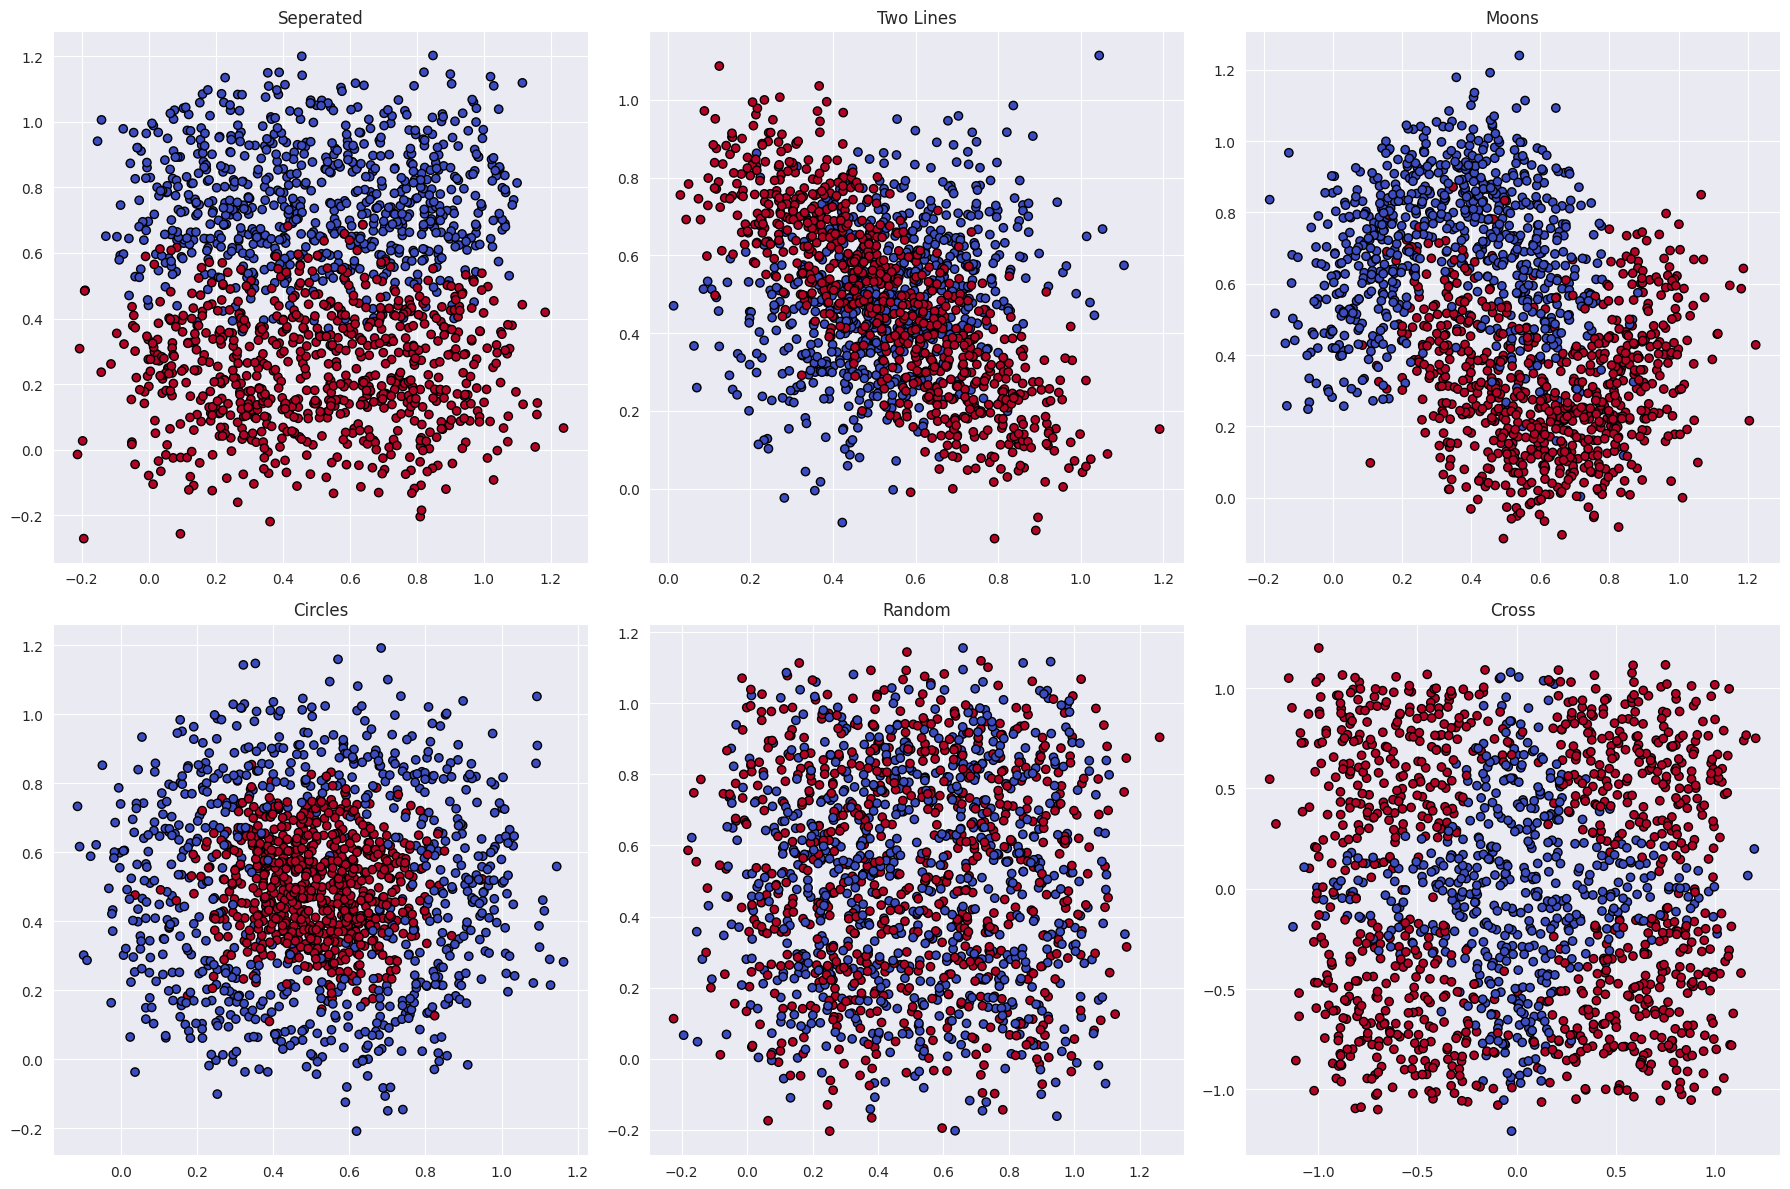

In [8]:
# Generate and plot datasets
datasets = generate_datasets(n_samples=1500, noise_level=0.1, gaussian_noise=0.1)
plot_datasets(datasets)

In [32]:
def plot_decision_boundary(model, X, y, ax):
    """Plots decision boundary for a 2D dataset on a given subplot axis."""
    h = 0.02  # Step size for meshgrid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    try:
        if hasattr(model, "predict_proba"):
            Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] > 0.5
        elif hasattr(model, "decision_function"):
            Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]) > 0
        else:
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

        Z = Z.reshape(xx.shape)

        # Plot decision regions
        ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
        ax.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=ListedColormap(['red', 'blue']))

        # Labels
        ax.set_xlabel("Feature 1")
        ax.set_ylabel("Feature 2")

    except Exception as e:
        # ax.set_title("Error: Decision Boundary Unavailable")
        print(f"Error plotting decision boundary: {e}")


In [33]:
def evaluate_model(model, model_name, datasets):
    for name, (X, y) in datasets.items():
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)
        elif hasattr(model, "decision_function"):
            y_prob = model.decision_function(X_test)
        else:
            y_prob = None

        #validação cruzada
        # scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        # print(f"\n{name} - {model_name}")
        # print(f"Accuracy (cross-validation): {scores.mean():.4f} ± {scores.std():.4f}")

        fig, axes = plt.subplots(1, 4, figsize=(20, 4))

        axes = axes.ravel()

        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0])
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('Actual')
        axes[0].set_title(f'Confusion Matrix - {name}')

        if len(np.unique(y)) == 2 and y_prob is not None:
            fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1])
            roc_auc = auc(fpr, tpr)
            axes[1].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
            axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
            axes[1].set_xlabel('False Positive Rate')
            axes[1].set_ylabel('True Positive Rate')
            axes[1].set_title(f'ROC Curve - {name}')
            axes[1].legend()
        else:
            axes[1].axis('off')  # Hide this plot if ROC is not applicable



        # Decision Boundary (Only for 2D binary classification)
        if X.shape[1] == 2 and len(np.unique(y)) == 2:
            plot_decision_boundary(model, X_test, y_pred, axes[2])
            axes[2].set_title(f"Decision Boundary (Pred) - {name} ({model_name})")
        else:
            axes[2].axis('off')

        if X.shape[1] == 2 and len(np.unique(y)) == 2:
            plot_decision_boundary(model, X_test, y_test, axes[3])
            axes[3].set_title(f"Decision Boundary (Real) - {name} ({model_name})")
        else:
            axes[2].axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Classification Report {name}:")
        print(classification_report(y_test, y_pred, zero_division=1))


        if X.shape[1] == 2 and len(np.unique(y)) == 2:
            plot_decision_boundary(model, X, y, f"Decision Boundary - {name} ({model_name})")

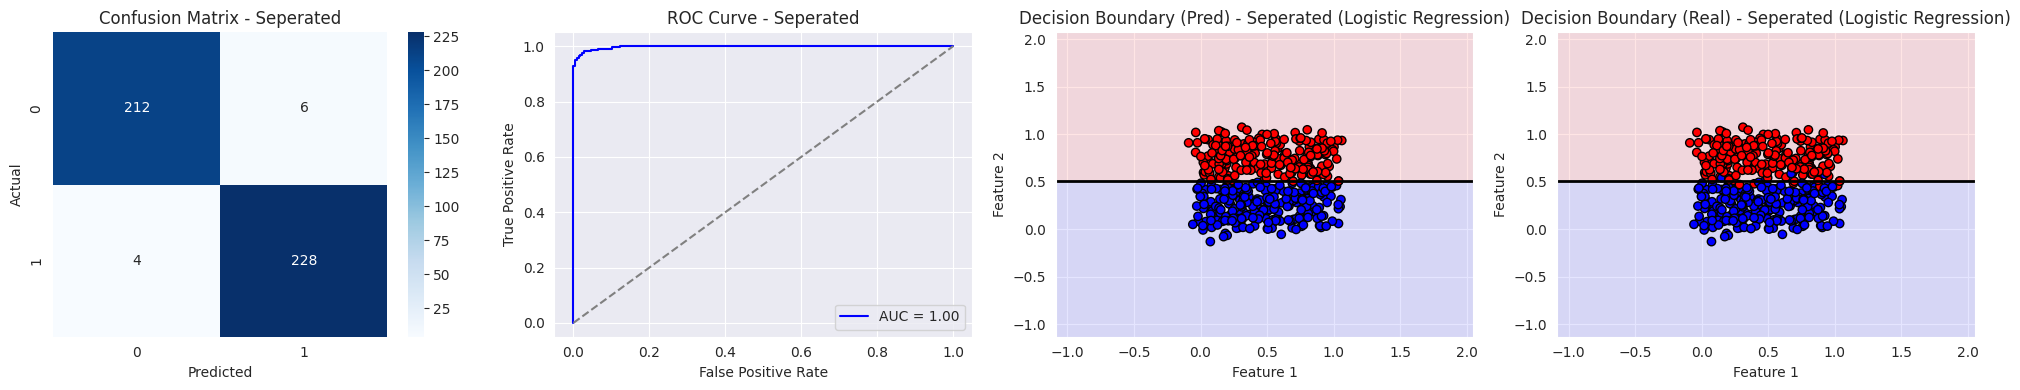

Classification Report Seperated:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       218
         1.0       0.97      0.98      0.98       232

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


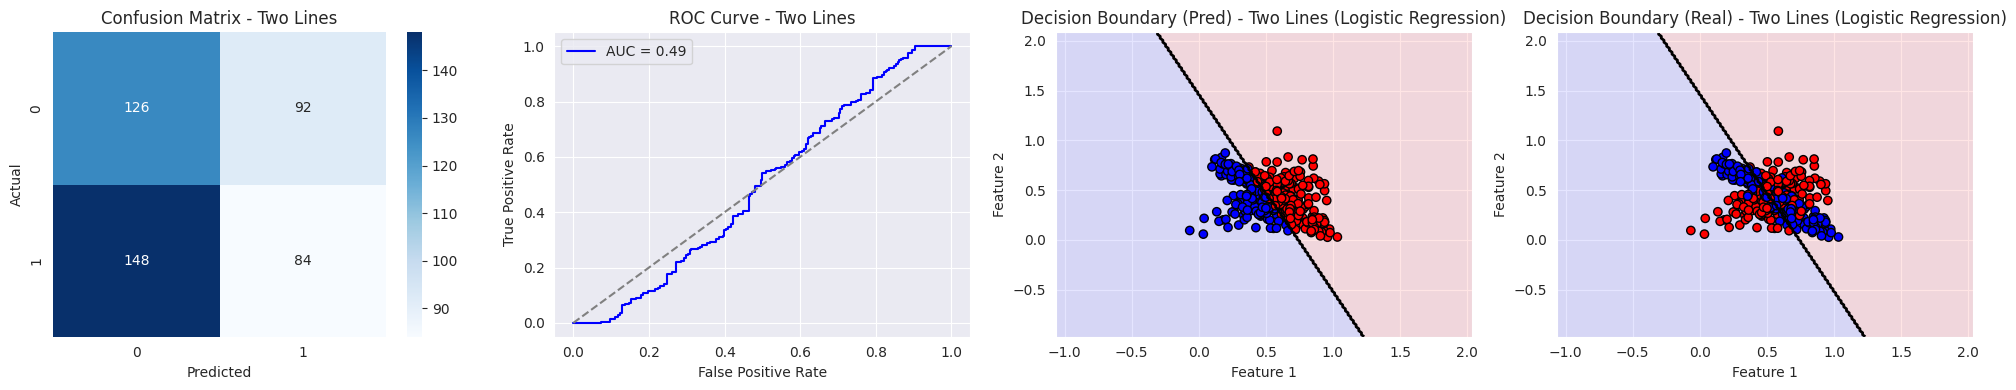

Classification Report Two Lines:
              precision    recall  f1-score   support

         0.0       0.46      0.58      0.51       218
         1.0       0.48      0.36      0.41       232

    accuracy                           0.47       450
   macro avg       0.47      0.47      0.46       450
weighted avg       0.47      0.47      0.46       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


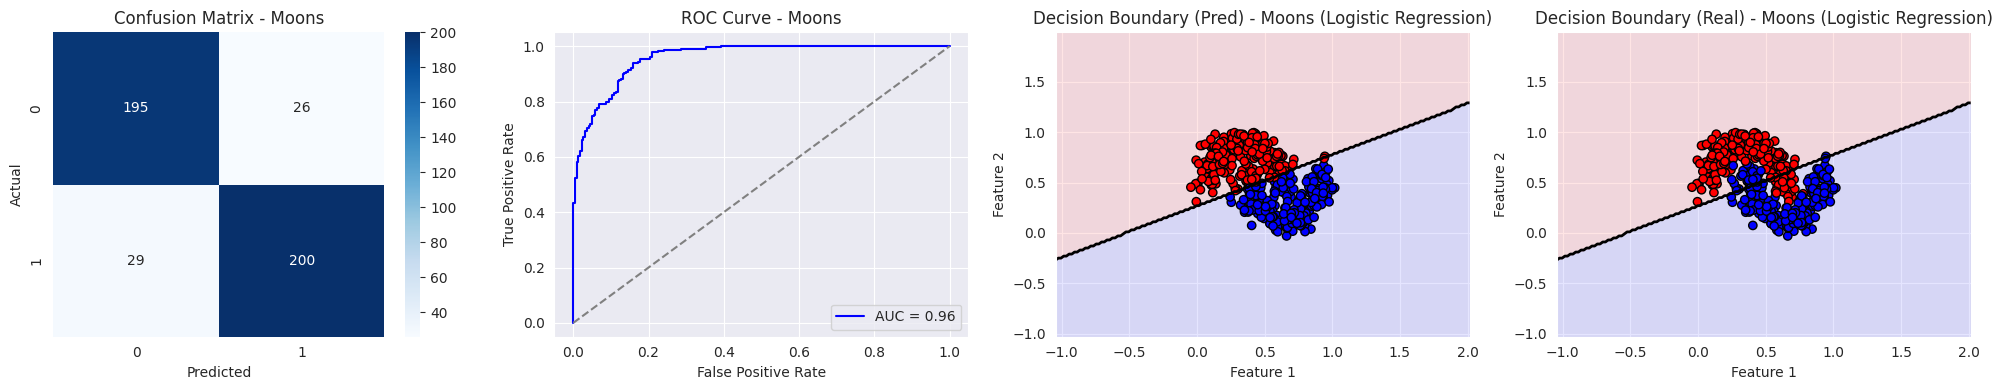

Classification Report Moons:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       221
           1       0.88      0.87      0.88       229

    accuracy                           0.88       450
   macro avg       0.88      0.88      0.88       450
weighted avg       0.88      0.88      0.88       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


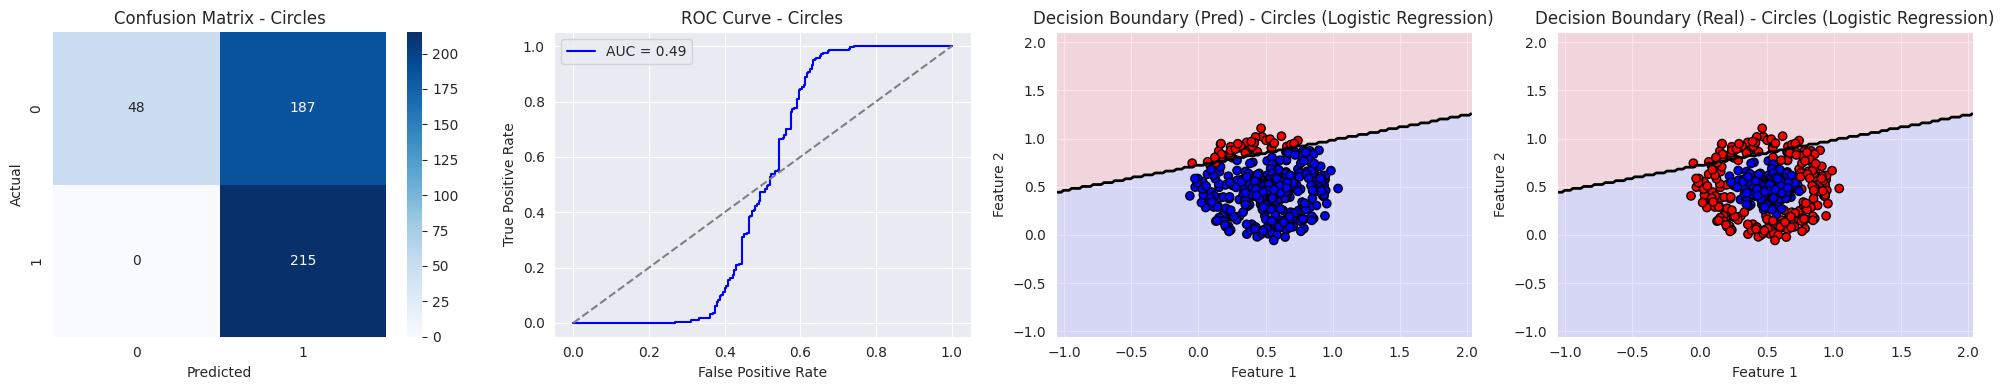

Classification Report Circles:
              precision    recall  f1-score   support

           0       1.00      0.20      0.34       235
           1       0.53      1.00      0.70       215

    accuracy                           0.58       450
   macro avg       0.77      0.60      0.52       450
weighted avg       0.78      0.58      0.51       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


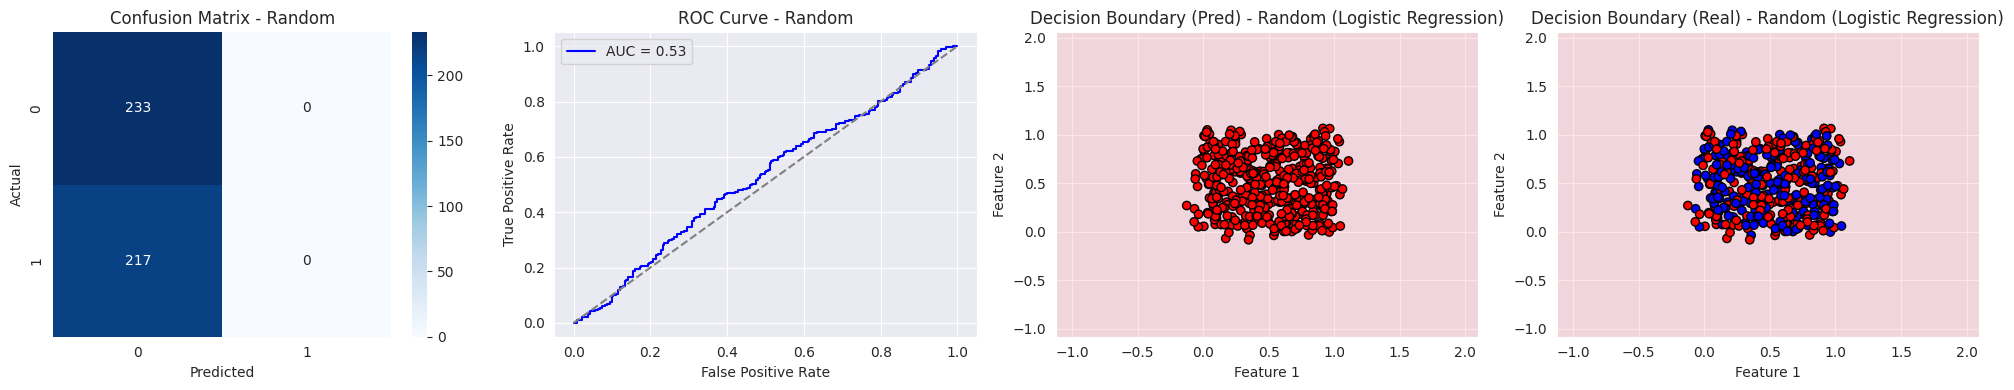

Classification Report Random:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       233
           1       1.00      0.00      0.00       217

    accuracy                           0.52       450
   macro avg       0.76      0.50      0.34       450
weighted avg       0.75      0.52      0.35       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


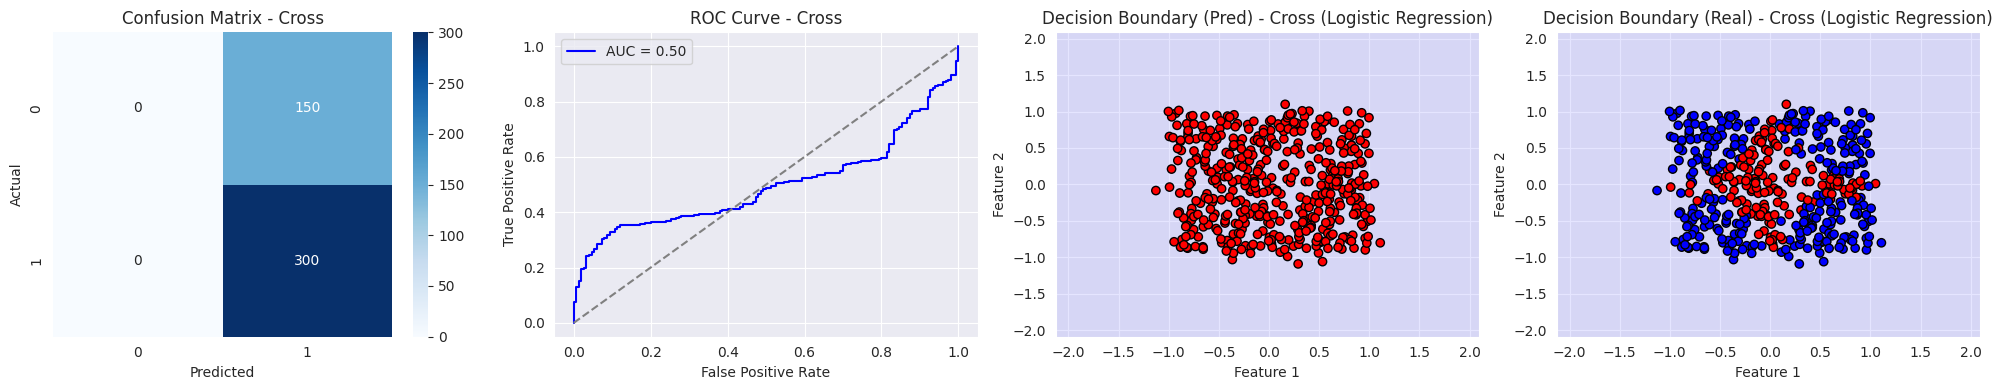

Classification Report Cross:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       150
           1       0.67      1.00      0.80       300

    accuracy                           0.67       450
   macro avg       0.83      0.50      0.40       450
weighted avg       0.78      0.67      0.53       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


In [34]:
evaluate_model(LogisticRegression(), "Logistic Regression", datasets)

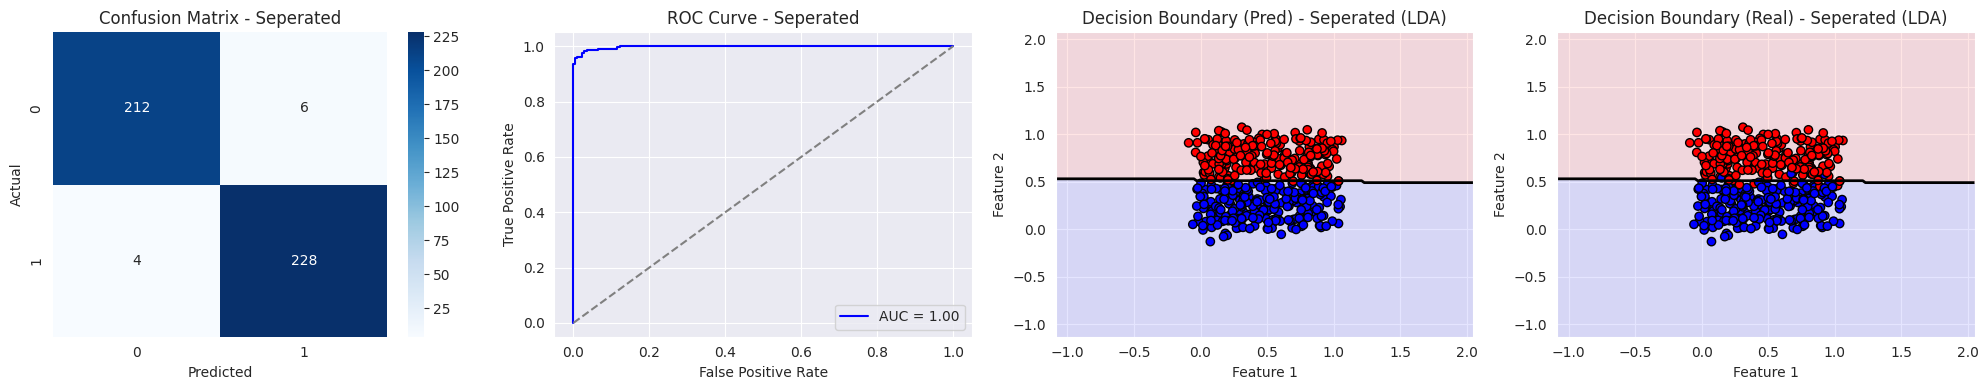

Classification Report Seperated:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       218
         1.0       0.97      0.98      0.98       232

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


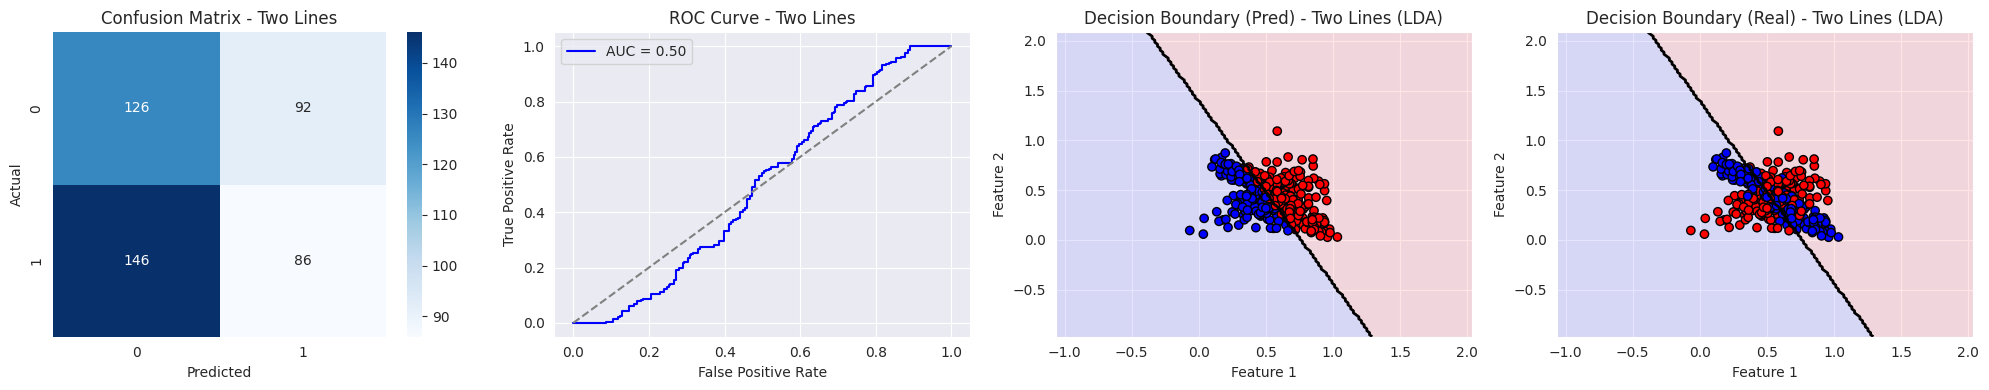

Classification Report Two Lines:
              precision    recall  f1-score   support

         0.0       0.46      0.58      0.51       218
         1.0       0.48      0.37      0.42       232

    accuracy                           0.47       450
   macro avg       0.47      0.47      0.47       450
weighted avg       0.47      0.47      0.47       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


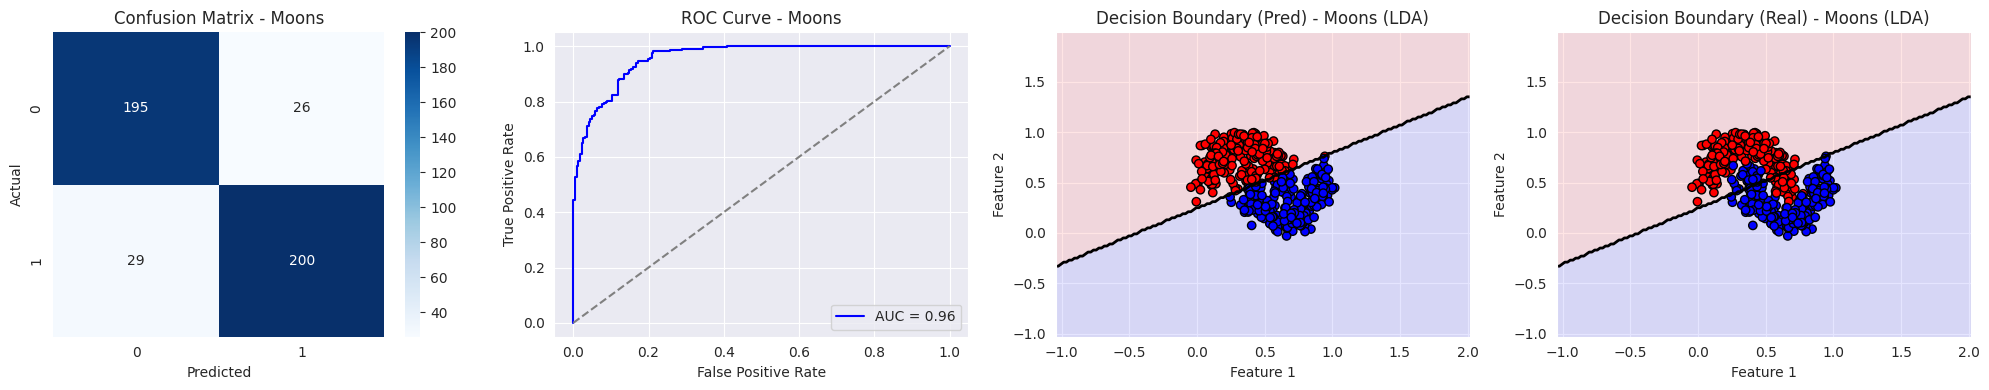

Classification Report Moons:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       221
           1       0.88      0.87      0.88       229

    accuracy                           0.88       450
   macro avg       0.88      0.88      0.88       450
weighted avg       0.88      0.88      0.88       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


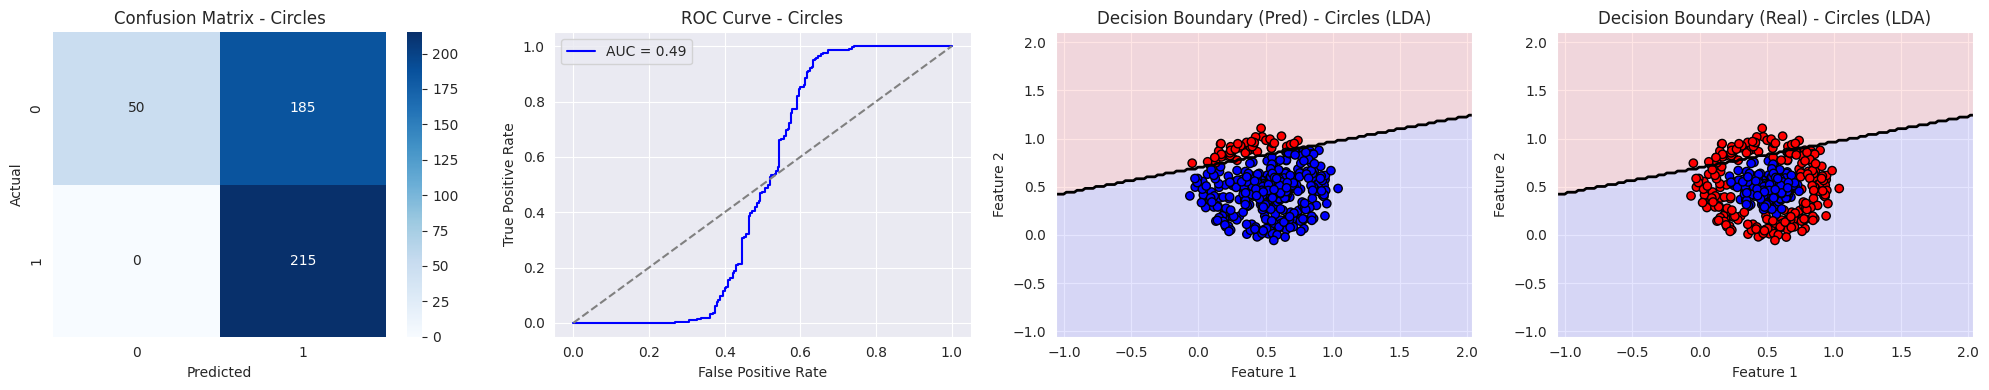

Classification Report Circles:
              precision    recall  f1-score   support

           0       1.00      0.21      0.35       235
           1       0.54      1.00      0.70       215

    accuracy                           0.59       450
   macro avg       0.77      0.61      0.53       450
weighted avg       0.78      0.59      0.52       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


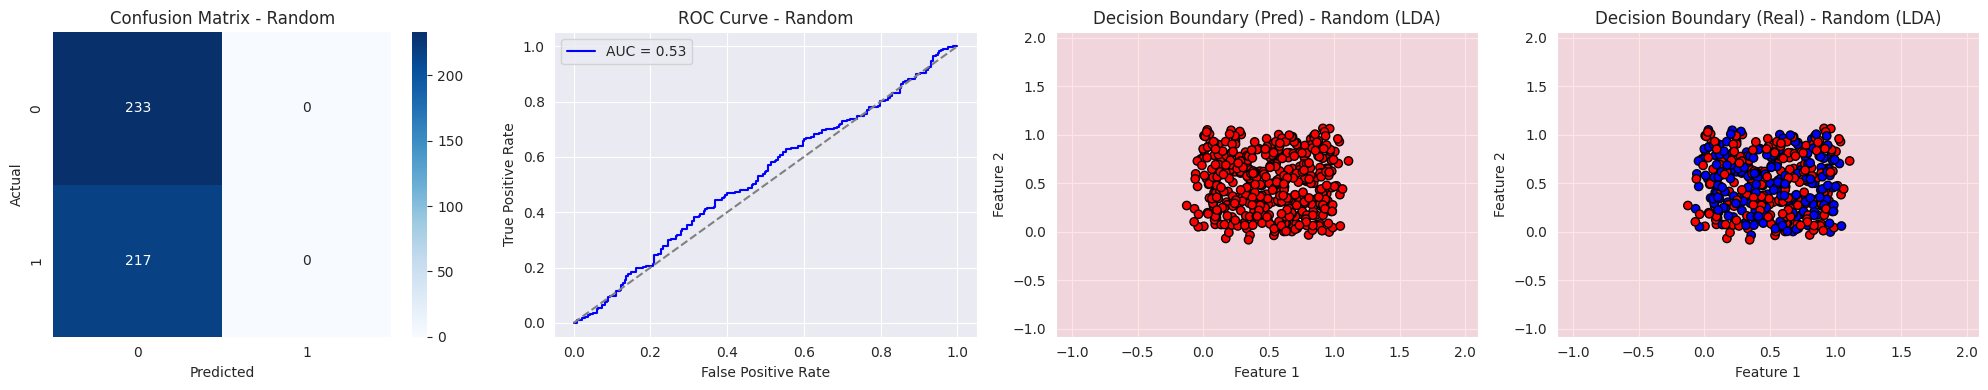

Classification Report Random:
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       233
           1       1.00      0.00      0.00       217

    accuracy                           0.52       450
   macro avg       0.76      0.50      0.34       450
weighted avg       0.75      0.52      0.35       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


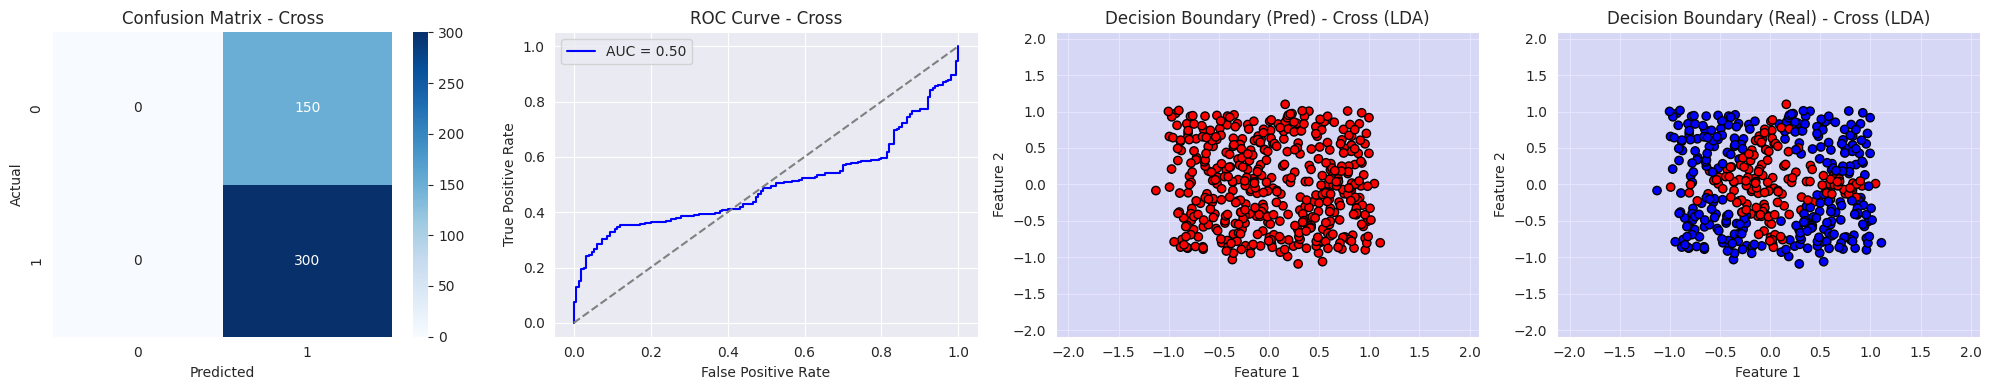

Classification Report Cross:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       150
           1       0.67      1.00      0.80       300

    accuracy                           0.67       450
   macro avg       0.83      0.50      0.40       450
weighted avg       0.78      0.67      0.53       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


In [35]:
evaluate_model(LinearDiscriminantAnalysis(), "LDA", datasets)

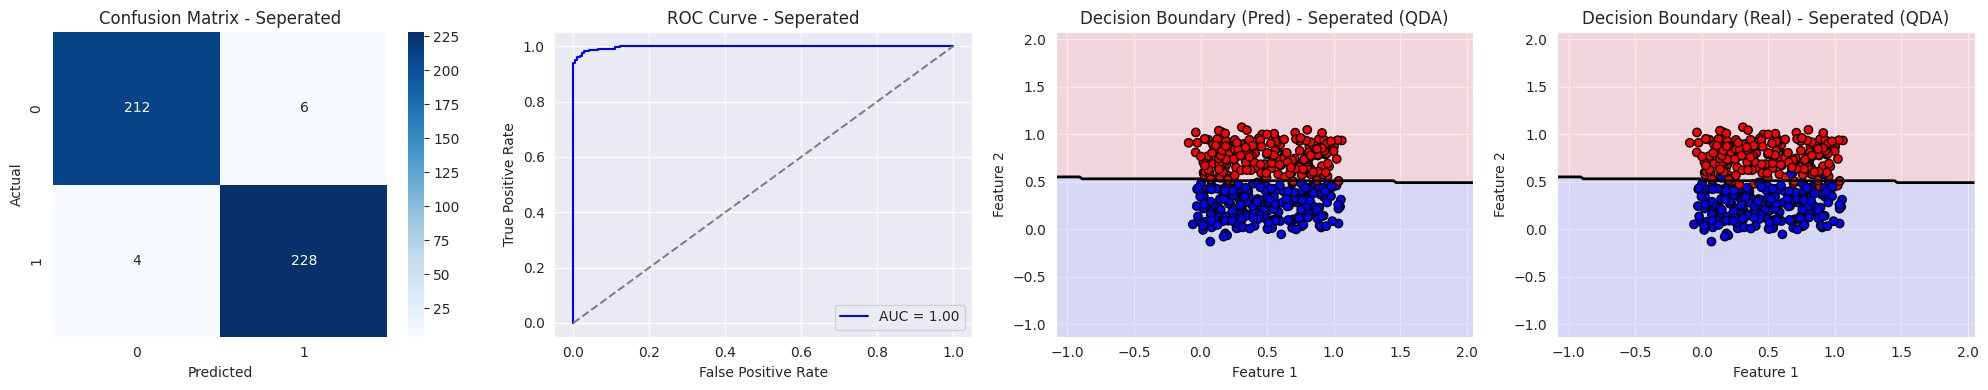

Classification Report Seperated:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       218
         1.0       0.97      0.98      0.98       232

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


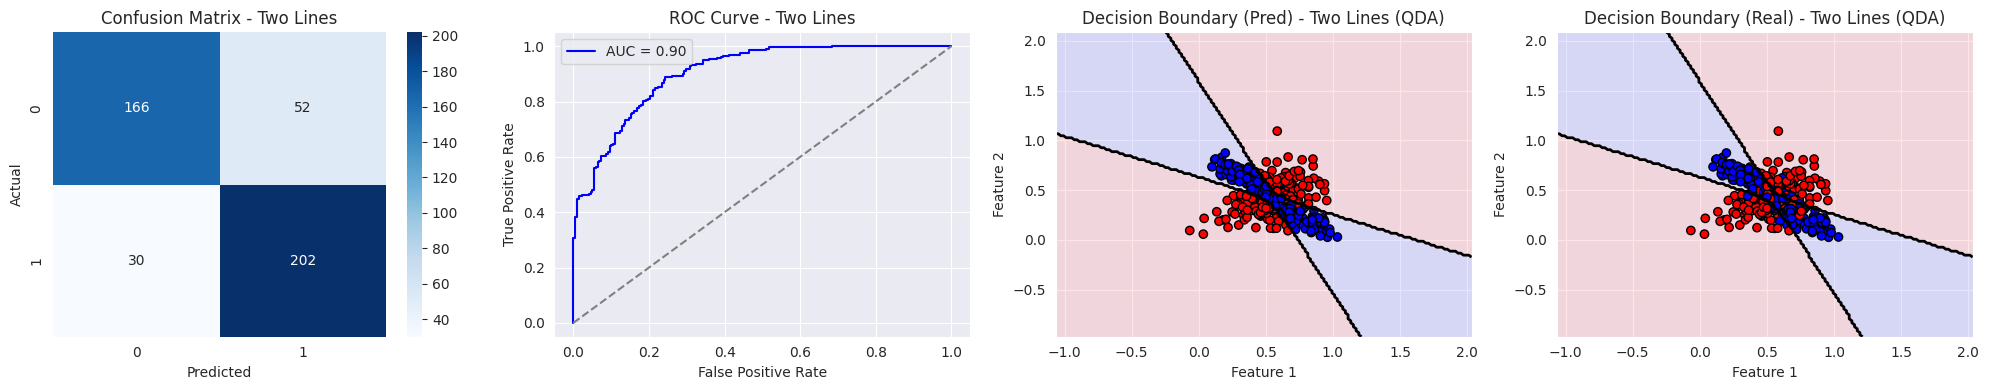

Classification Report Two Lines:
              precision    recall  f1-score   support

         0.0       0.85      0.76      0.80       218
         1.0       0.80      0.87      0.83       232

    accuracy                           0.82       450
   macro avg       0.82      0.82      0.82       450
weighted avg       0.82      0.82      0.82       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


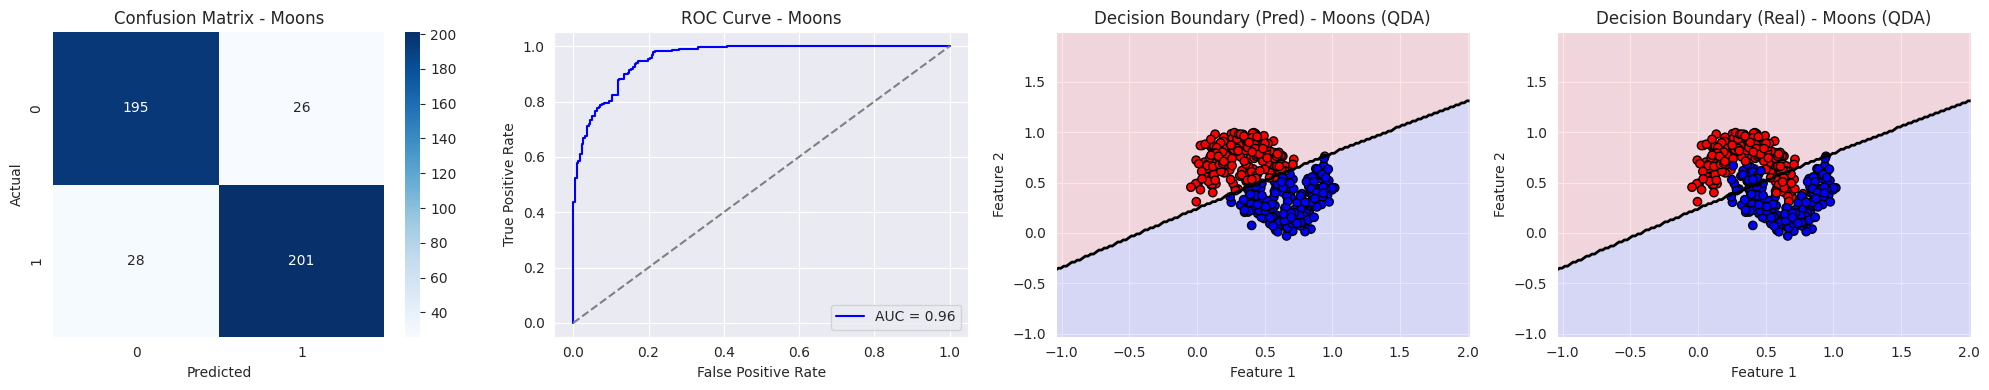

Classification Report Moons:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       221
           1       0.89      0.88      0.88       229

    accuracy                           0.88       450
   macro avg       0.88      0.88      0.88       450
weighted avg       0.88      0.88      0.88       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


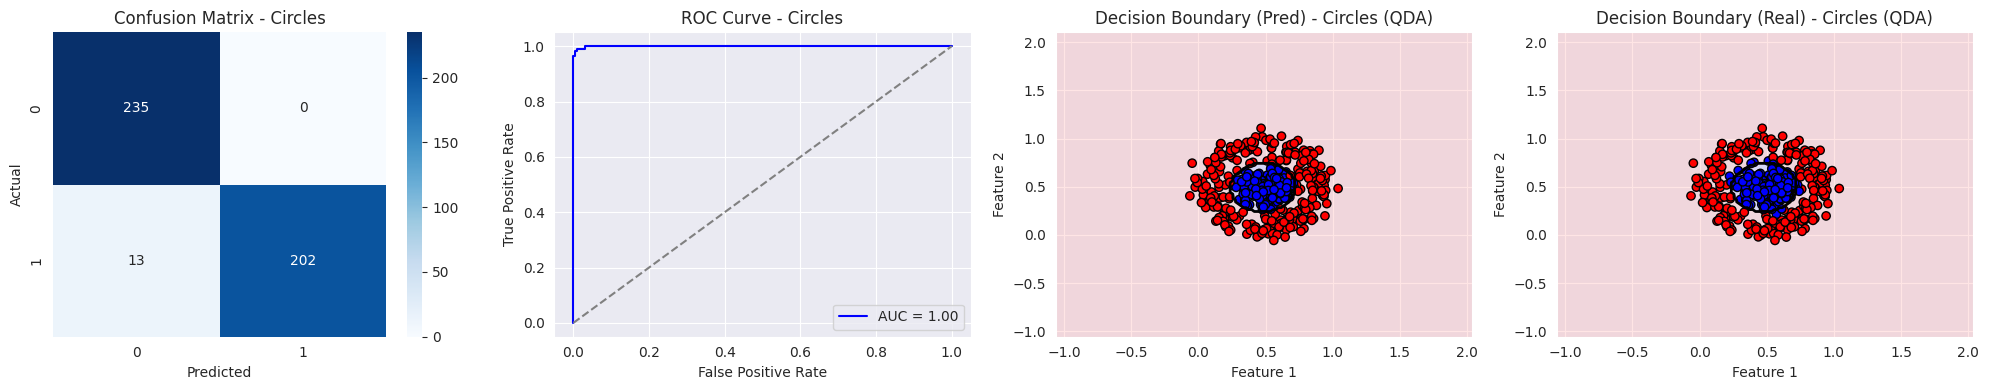

Classification Report Circles:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       235
           1       1.00      0.94      0.97       215

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


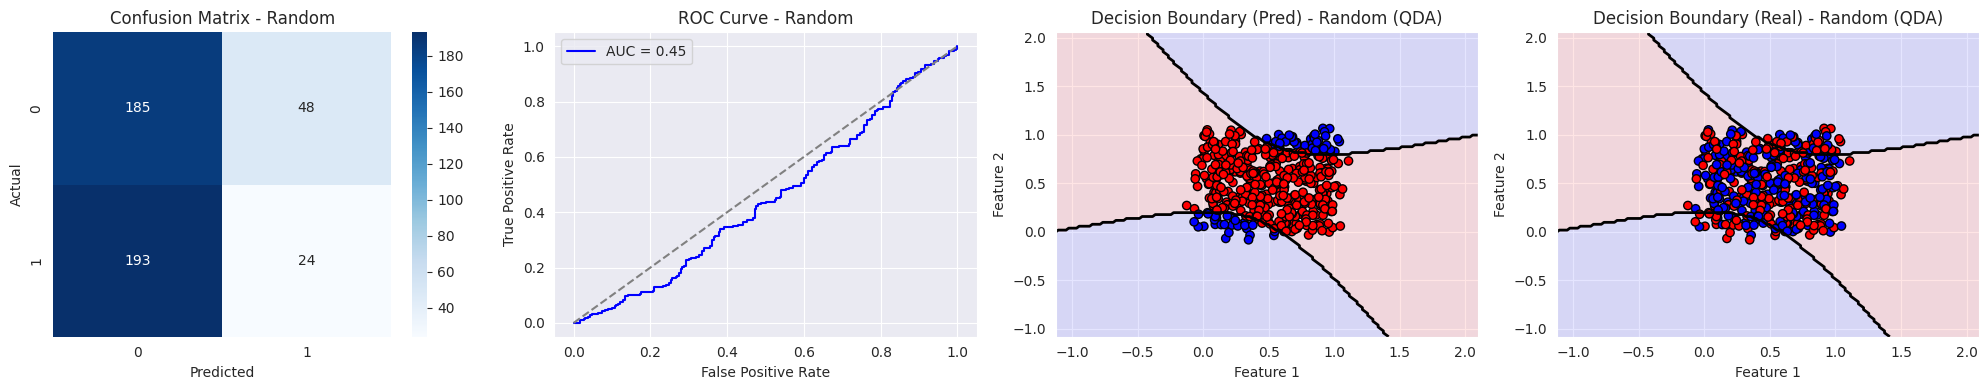

Classification Report Random:
              precision    recall  f1-score   support

           0       0.49      0.79      0.61       233
           1       0.33      0.11      0.17       217

    accuracy                           0.46       450
   macro avg       0.41      0.45      0.39       450
weighted avg       0.41      0.46      0.39       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


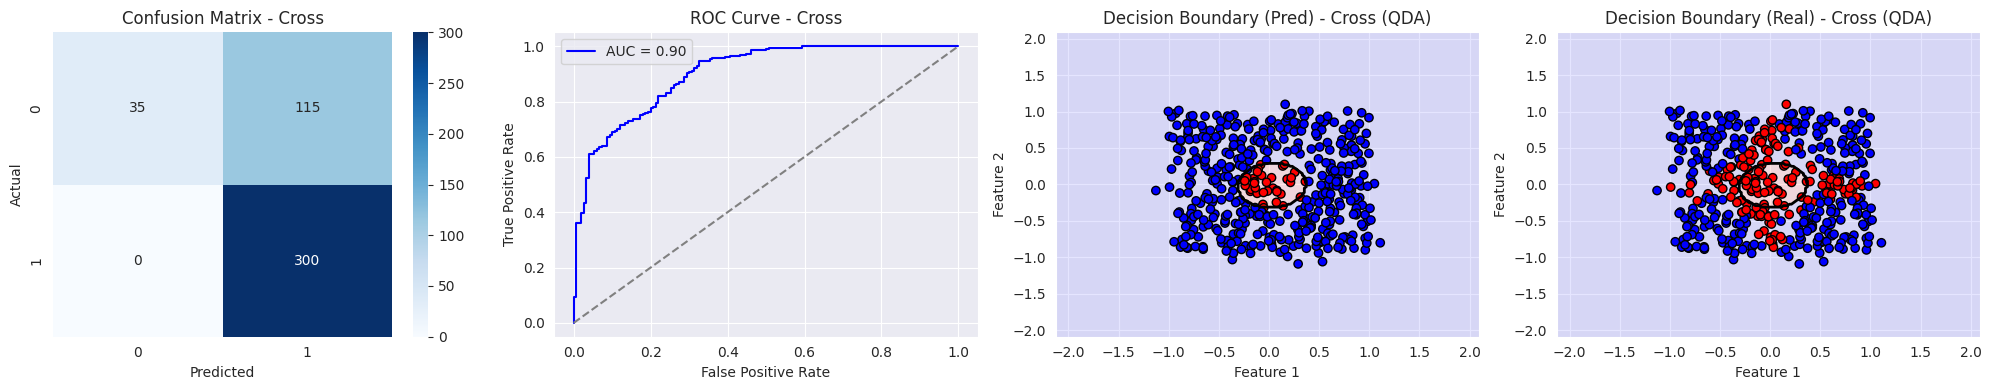

Classification Report Cross:
              precision    recall  f1-score   support

           0       1.00      0.23      0.38       150
           1       0.72      1.00      0.84       300

    accuracy                           0.74       450
   macro avg       0.86      0.62      0.61       450
weighted avg       0.82      0.74      0.69       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


In [36]:
evaluate_model(QuadraticDiscriminantAnalysis(), "QDA", datasets)


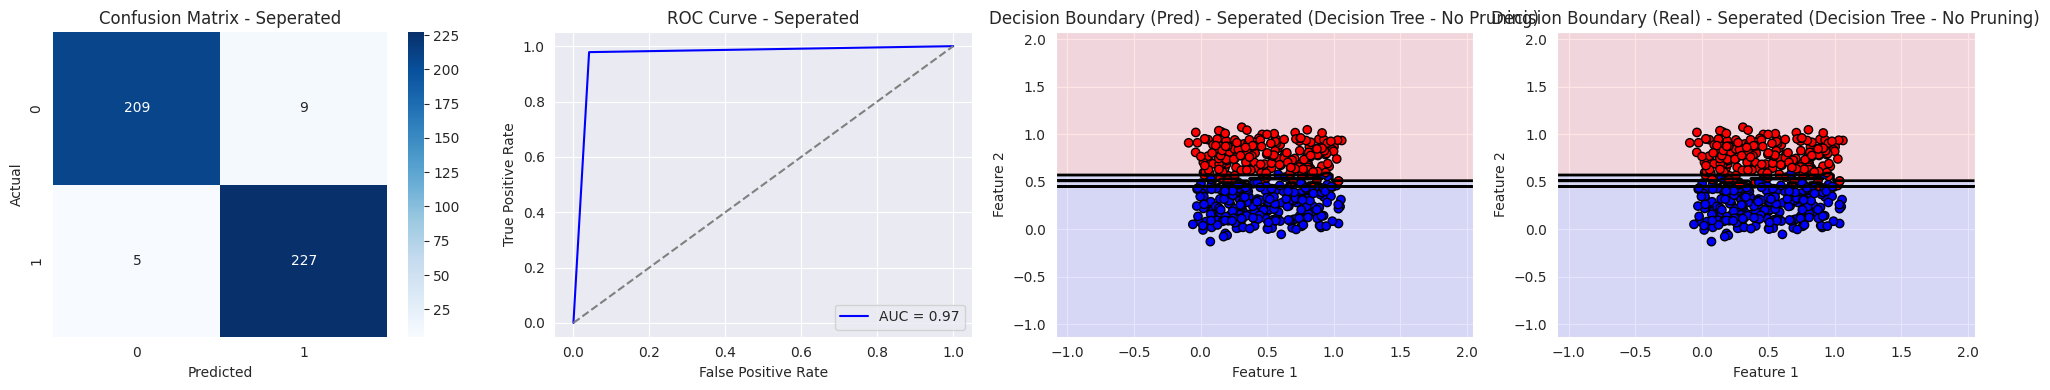

Classification Report Seperated:
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       218
         1.0       0.96      0.98      0.97       232

    accuracy                           0.97       450
   macro avg       0.97      0.97      0.97       450
weighted avg       0.97      0.97      0.97       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


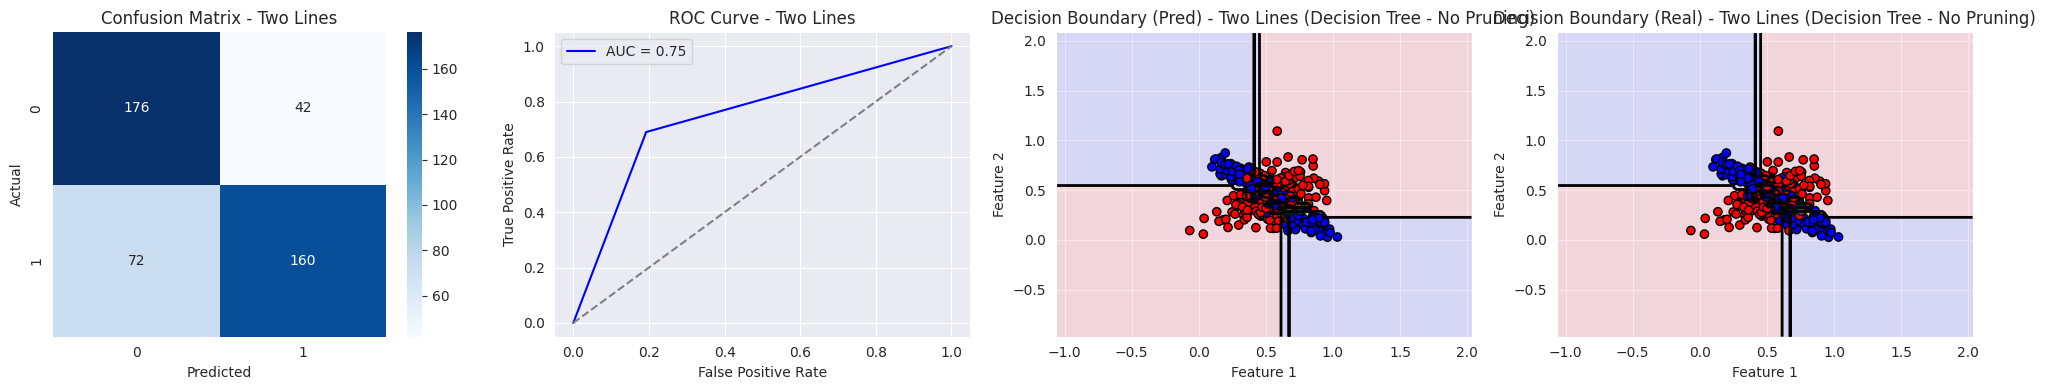

Classification Report Two Lines:
              precision    recall  f1-score   support

         0.0       0.71      0.81      0.76       218
         1.0       0.79      0.69      0.74       232

    accuracy                           0.75       450
   macro avg       0.75      0.75      0.75       450
weighted avg       0.75      0.75      0.75       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


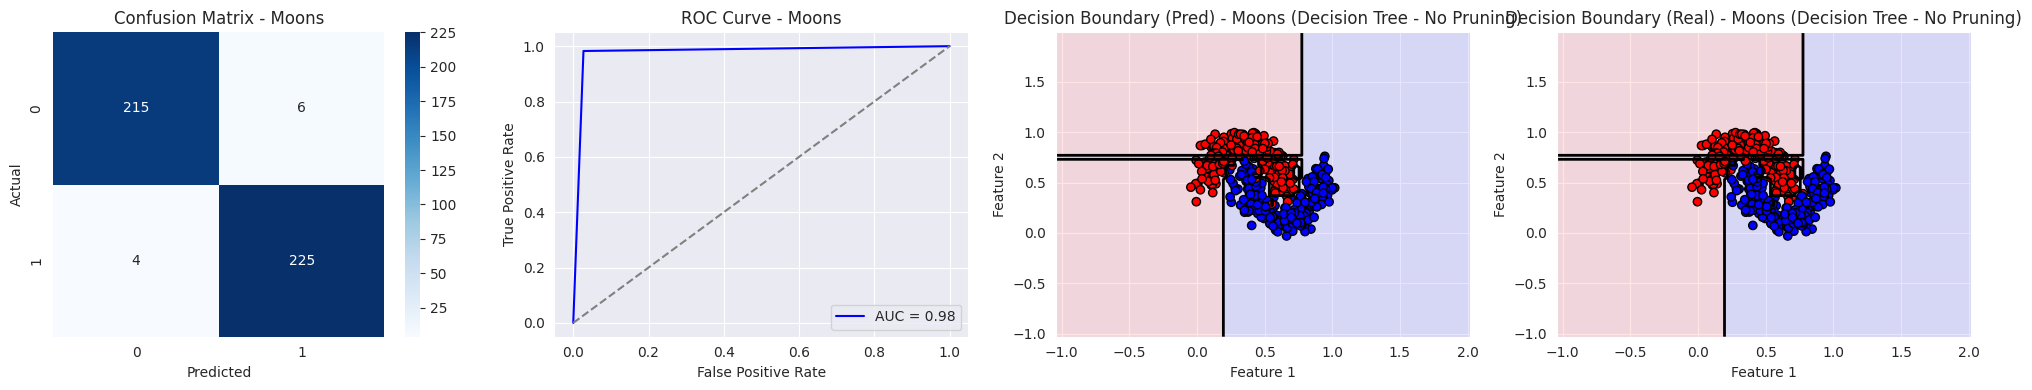

Classification Report Moons:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       221
           1       0.97      0.98      0.98       229

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


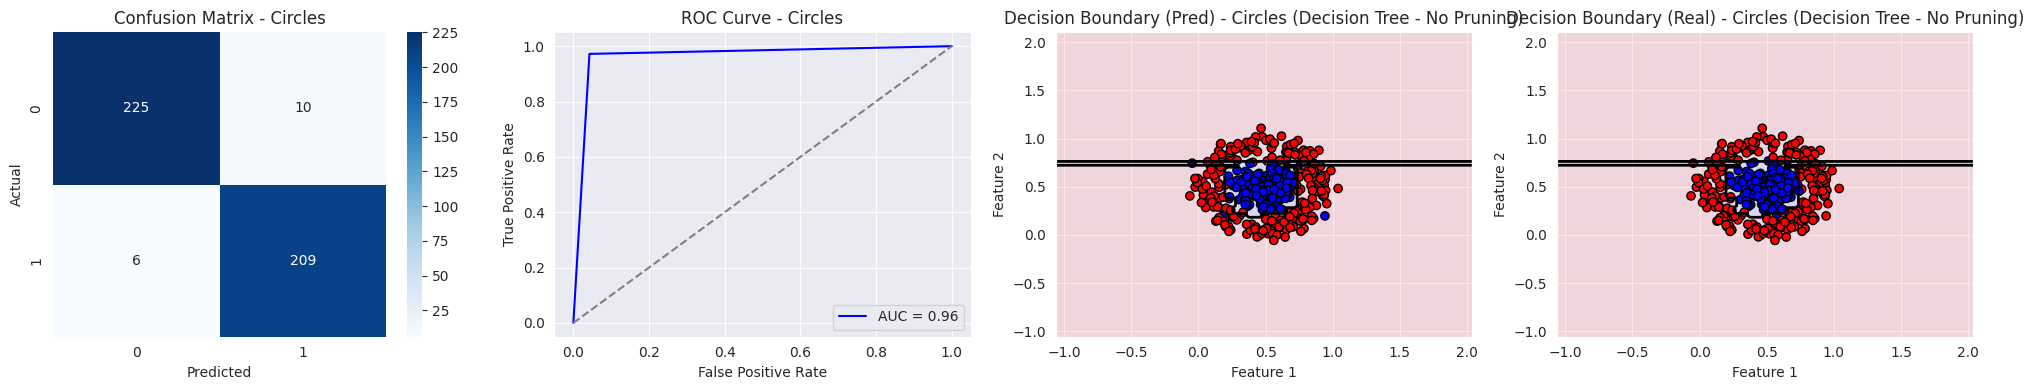

Classification Report Circles:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       235
           1       0.95      0.97      0.96       215

    accuracy                           0.96       450
   macro avg       0.96      0.96      0.96       450
weighted avg       0.96      0.96      0.96       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


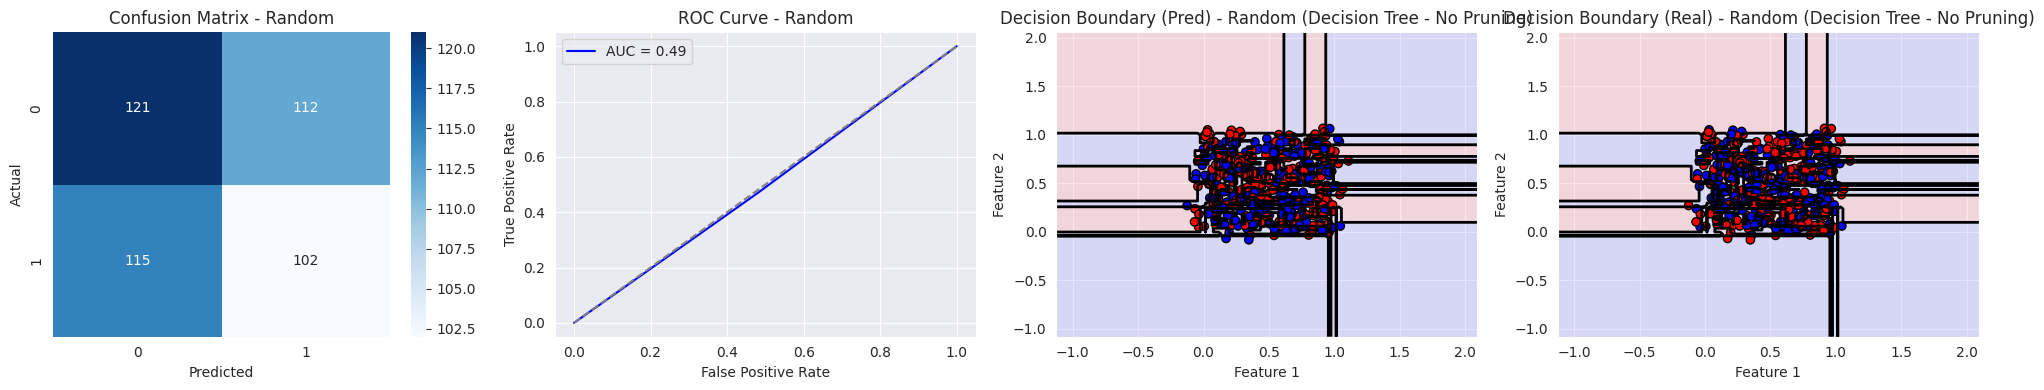

Classification Report Random:
              precision    recall  f1-score   support

           0       0.51      0.52      0.52       233
           1       0.48      0.47      0.47       217

    accuracy                           0.50       450
   macro avg       0.49      0.49      0.49       450
weighted avg       0.50      0.50      0.50       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


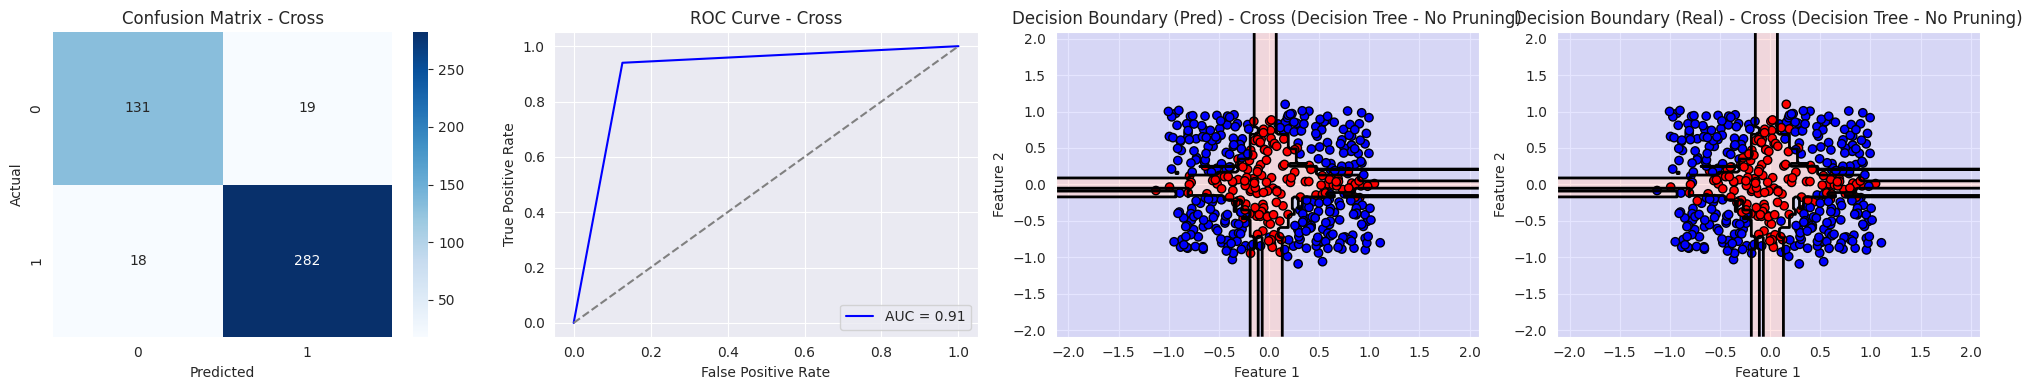

Classification Report Cross:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       150
           1       0.94      0.94      0.94       300

    accuracy                           0.92       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.92      0.92      0.92       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


In [37]:
evaluate_model(DecisionTreeClassifier(), "Decision Tree - No Pruning", datasets)

In [38]:
from sklearn.tree import plot_tree

def plot_decision_trees_for_all_datasets(datasets, max_depth=None):
    for name, (X, y) in datasets.items():
        if len(np.unique(y)) > 2:
            continue

        model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
        model.fit(X, y)

        plt.figure(figsize=(12, 6))
        plot_tree(model, filled=True, feature_names=["Feature 1", "Feature 2"], class_names=["Class 0", "Class 1"])
        plt.title(f"Decision Tree - {name} ")
        plt.show()


Decision Trees without pruning:


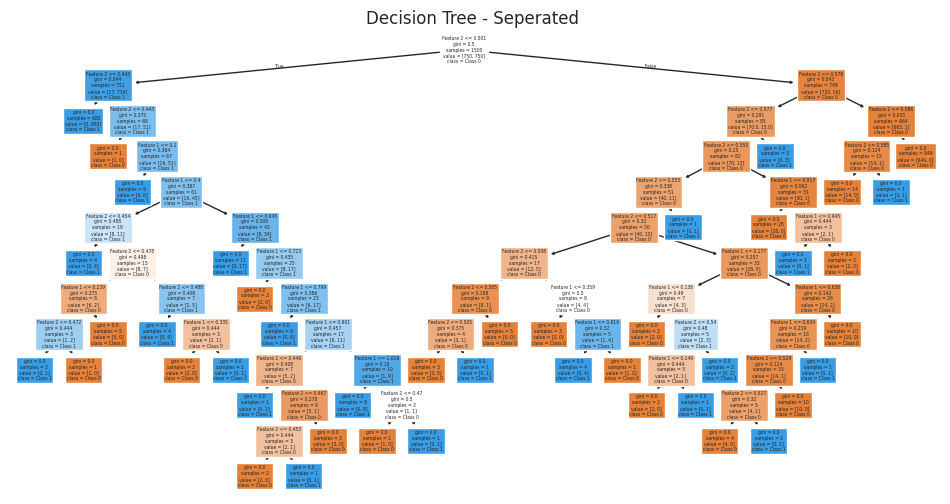

In [ ]:
print("Decision Trees without pruning:")
plot_decision_trees_for_all_datasets(datasets)


Seperated - Decision Tree - Max Depth = 2
Accuracy (cross-validation): 1.0000 ± 0.0000


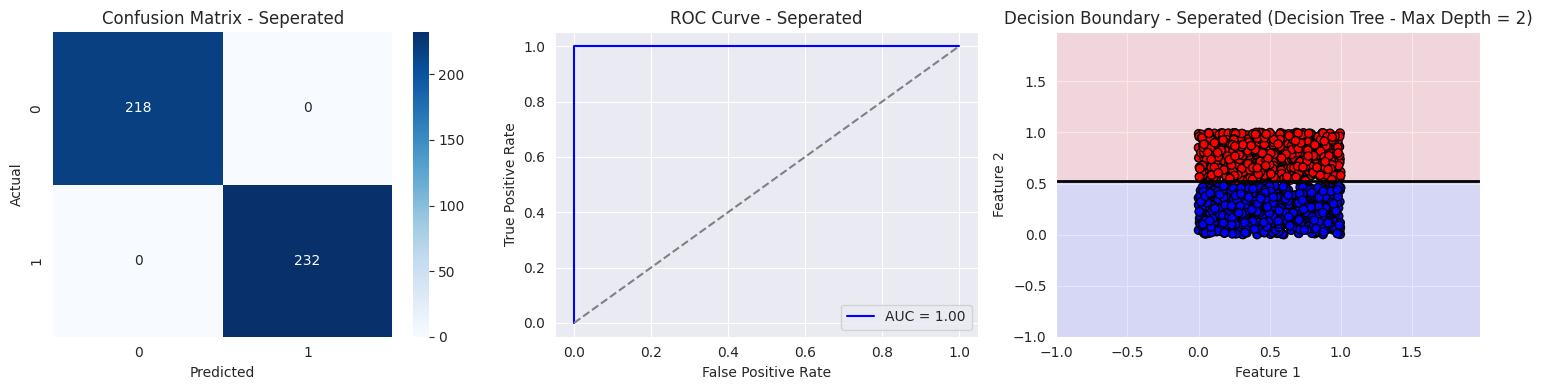

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       218
         1.0       1.00      1.00      1.00       232

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Two Lines - Decision Tree - Max Depth = 2
Accuracy (cross-validation): 0.4193 ± 0.1170


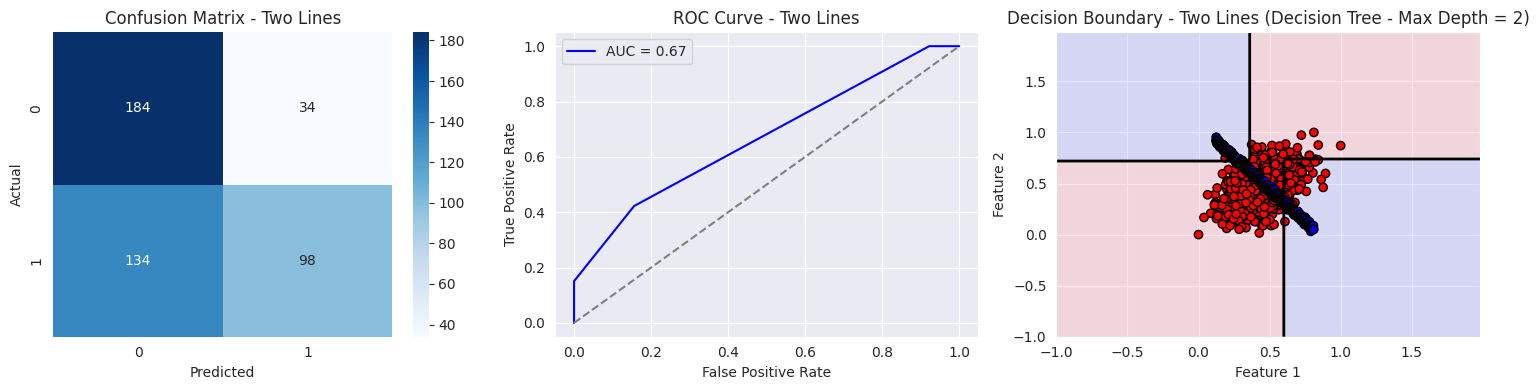

Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.84      0.69       218
         1.0       0.74      0.42      0.54       232

    accuracy                           0.63       450
   macro avg       0.66      0.63      0.61       450
weighted avg       0.66      0.63      0.61       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Moons - Decision Tree - Max Depth = 2
Accuracy (cross-validation): 0.9187 ± 0.0142


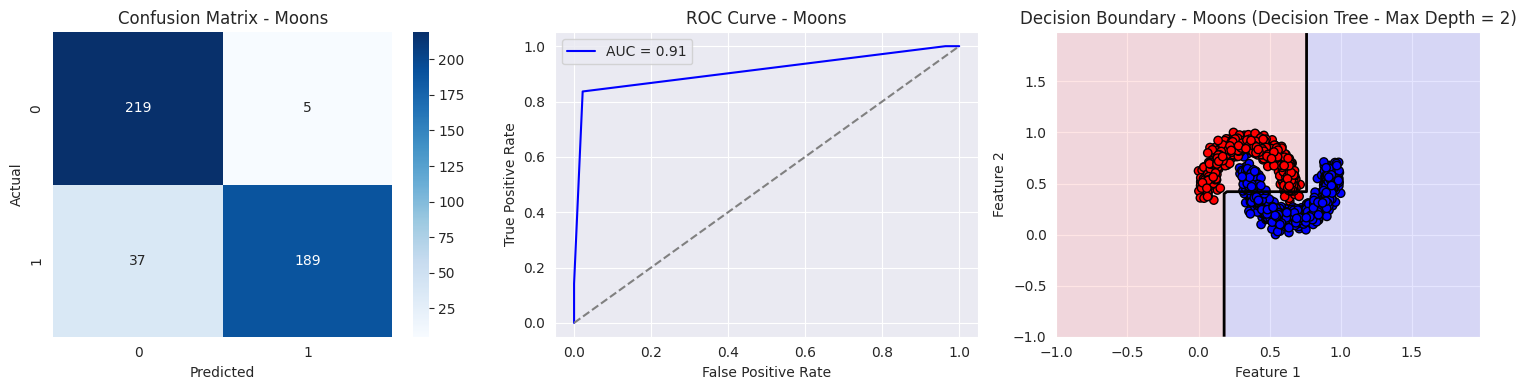

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       224
           1       0.97      0.84      0.90       226

    accuracy                           0.91       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.92      0.91      0.91       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Circles - Decision Tree - Max Depth = 2
Accuracy (cross-validation): 0.8300 ± 0.0252


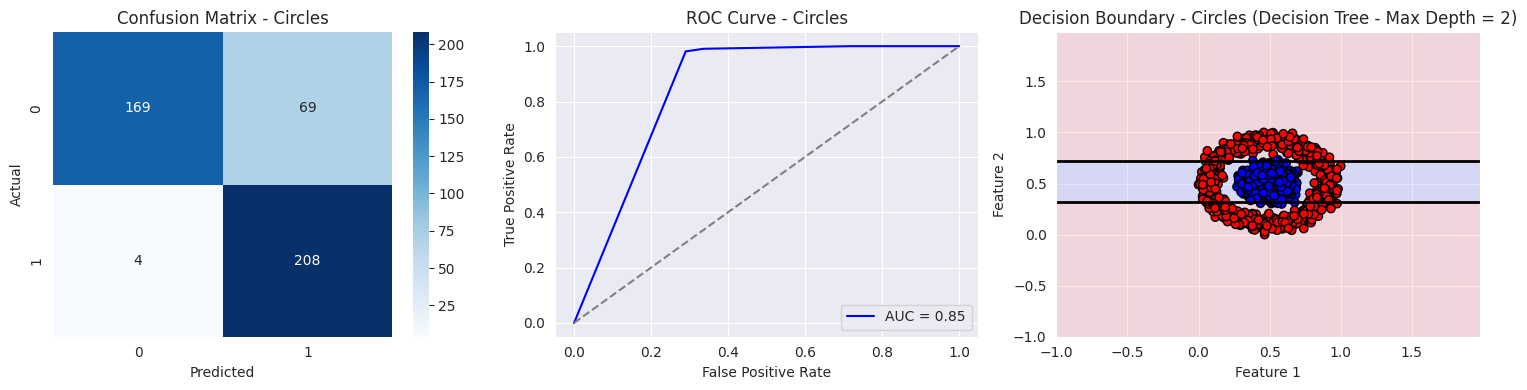

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.71      0.82       238
           1       0.75      0.98      0.85       212

    accuracy                           0.84       450
   macro avg       0.86      0.85      0.84       450
weighted avg       0.87      0.84      0.84       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Random - Decision Tree - Max Depth = 2
Accuracy (cross-validation): 0.5287 ± 0.0083


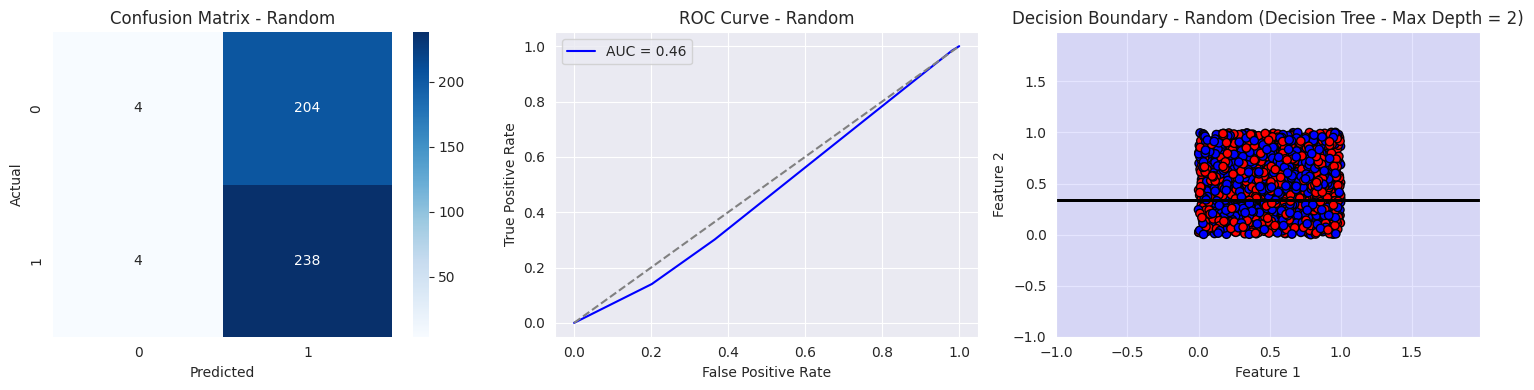

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.02      0.04       208
           1       0.54      0.98      0.70       242

    accuracy                           0.54       450
   macro avg       0.52      0.50      0.37       450
weighted avg       0.52      0.54      0.39       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Chess - Decision Tree - Max Depth = 2
Accuracy (cross-validation): 0.7733 ± 0.0291


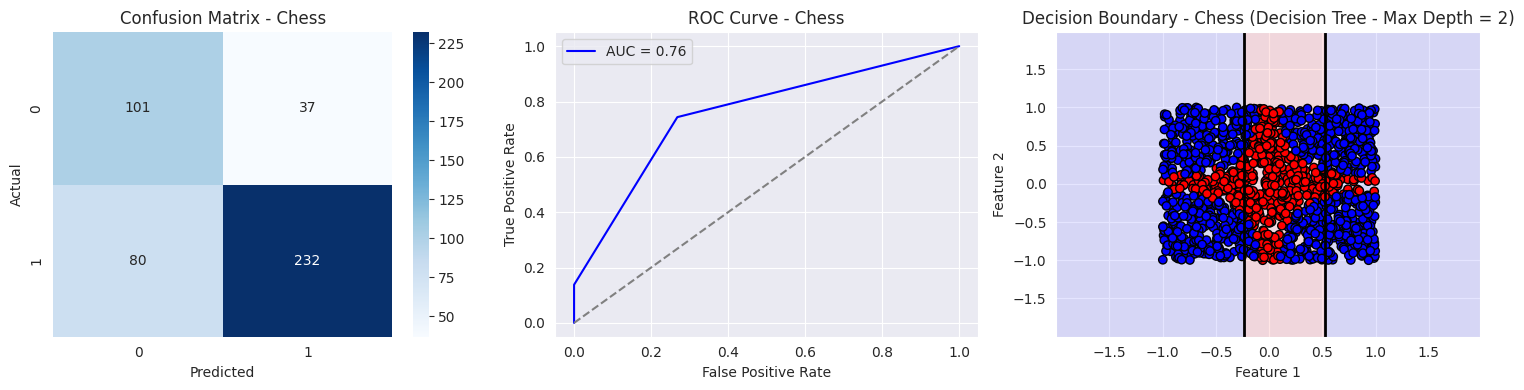

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.73      0.63       138
           1       0.86      0.74      0.80       312

    accuracy                           0.74       450
   macro avg       0.71      0.74      0.72       450
weighted avg       0.77      0.74      0.75       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


In [15]:
evaluate_model(DecisionTreeClassifier(max_depth=2), "Decision Tree - Max Depth = 2", datasets)


Decision Trees with max_depth=2:


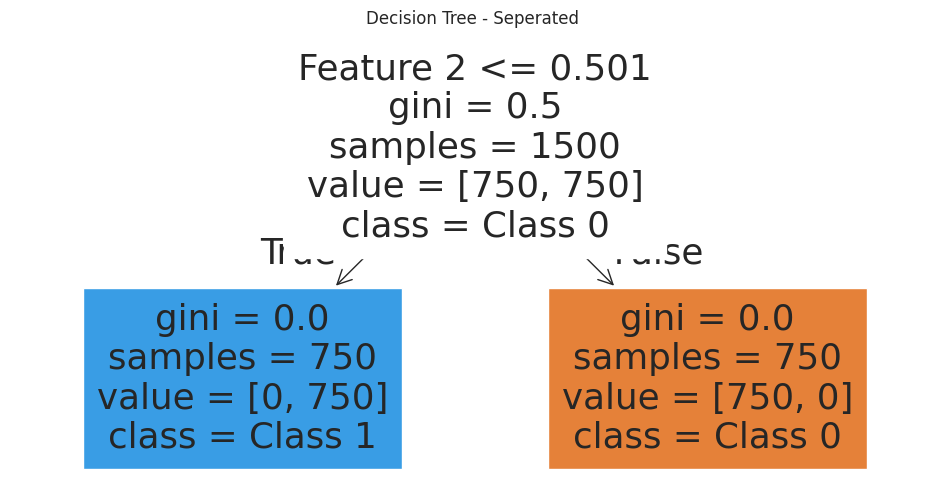

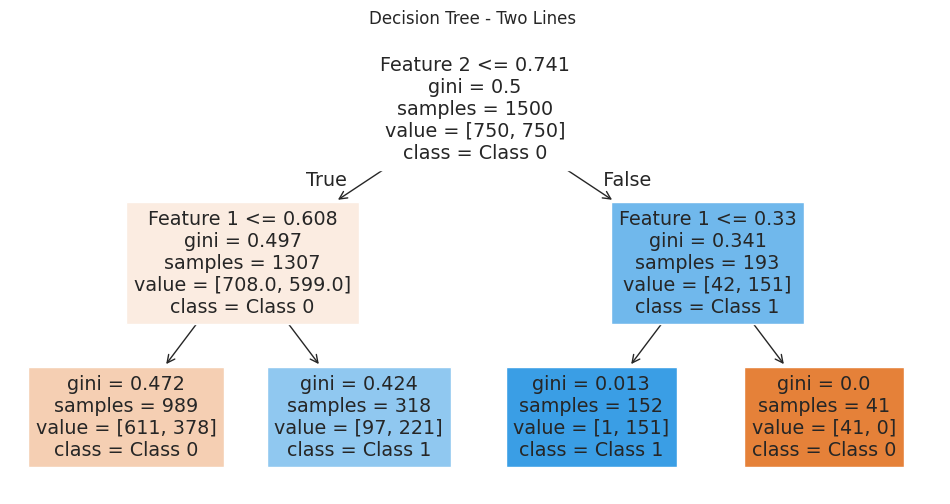

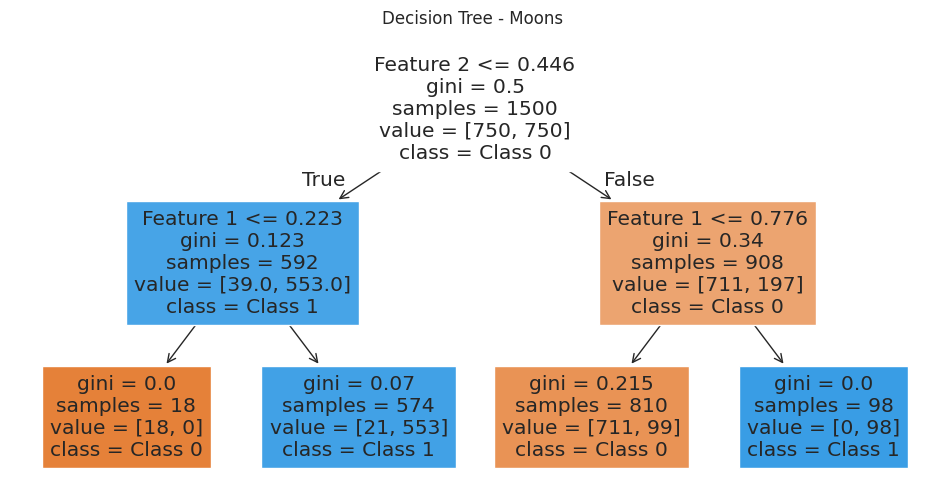

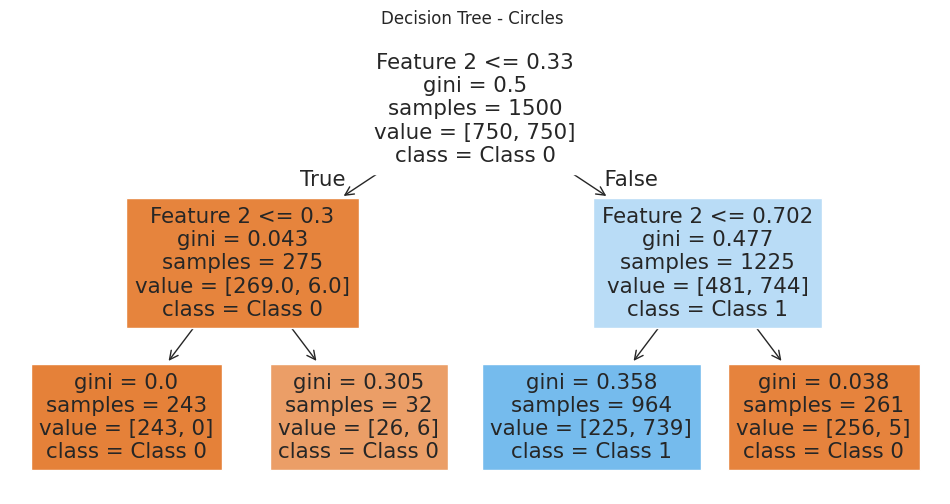

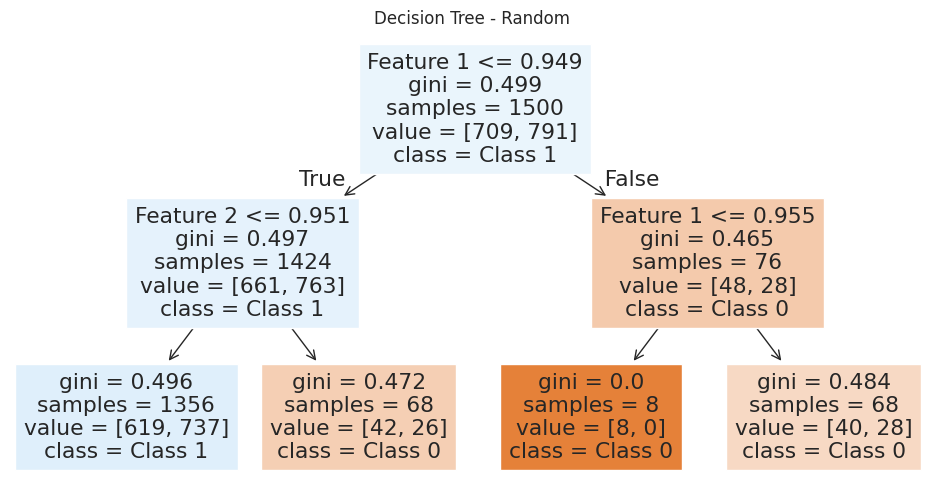

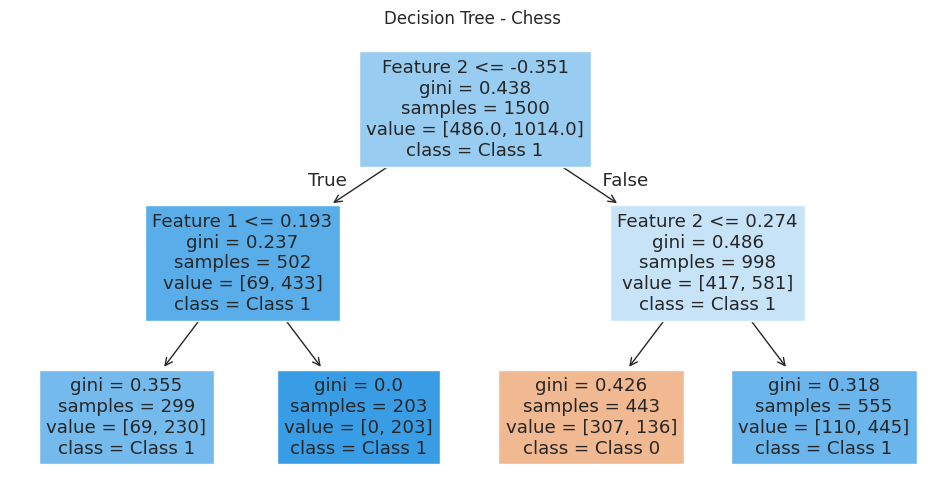

In [16]:
print("\nDecision Trees with max_depth=2:")
plot_decision_trees_for_all_datasets(datasets, max_depth=2)


Seperated - SVM Linear
Accuracy (cross-validation): 1.0000 ± 0.0000


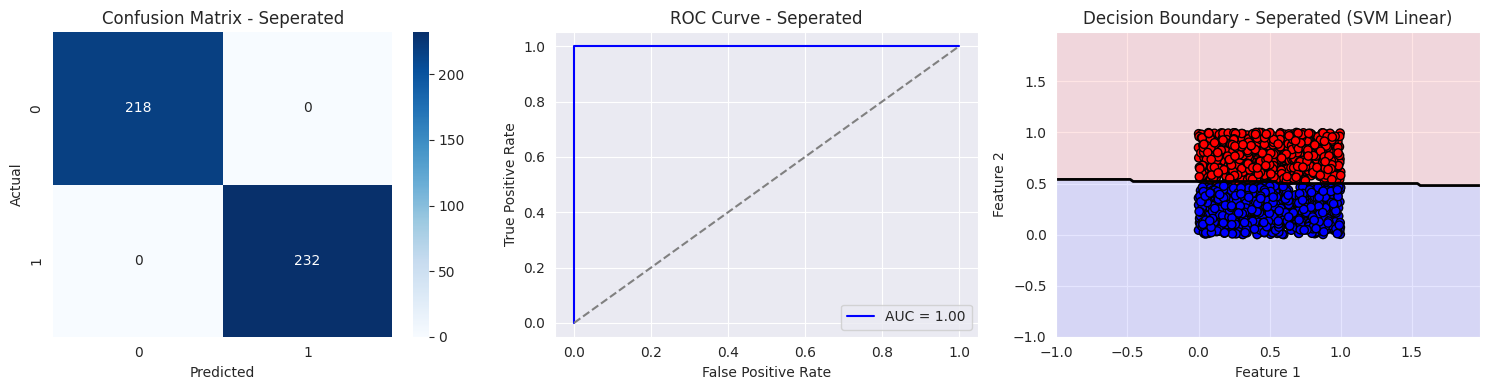

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       218
         1.0       1.00      1.00      1.00       232

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Two Lines - SVM Linear
Accuracy (cross-validation): 0.4727 ± 0.0436


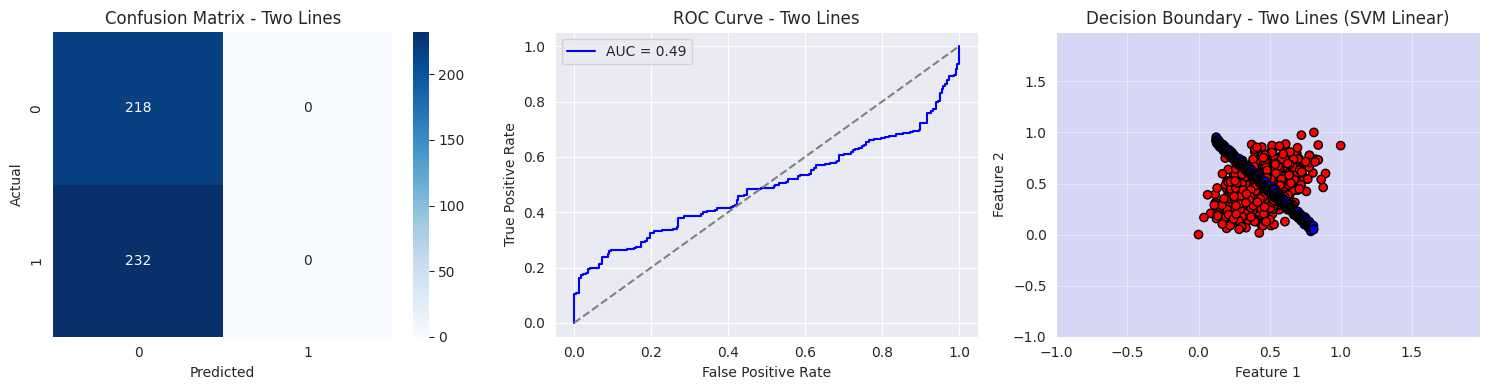

Classification Report:
              precision    recall  f1-score   support

         0.0       0.48      1.00      0.65       218
         1.0       1.00      0.00      0.00       232

    accuracy                           0.48       450
   macro avg       0.74      0.50      0.33       450
weighted avg       0.75      0.48      0.32       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Moons - SVM Linear
Accuracy (cross-validation): 0.8793 ± 0.0161


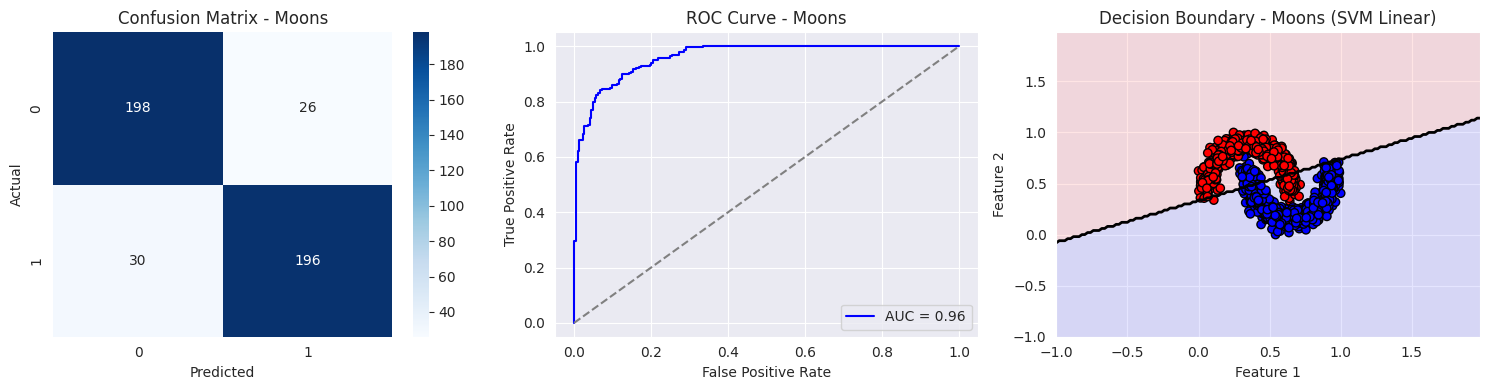

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       224
           1       0.88      0.87      0.88       226

    accuracy                           0.88       450
   macro avg       0.88      0.88      0.88       450
weighted avg       0.88      0.88      0.88       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Circles - SVM Linear
Accuracy (cross-validation): 0.6367 ± 0.0073


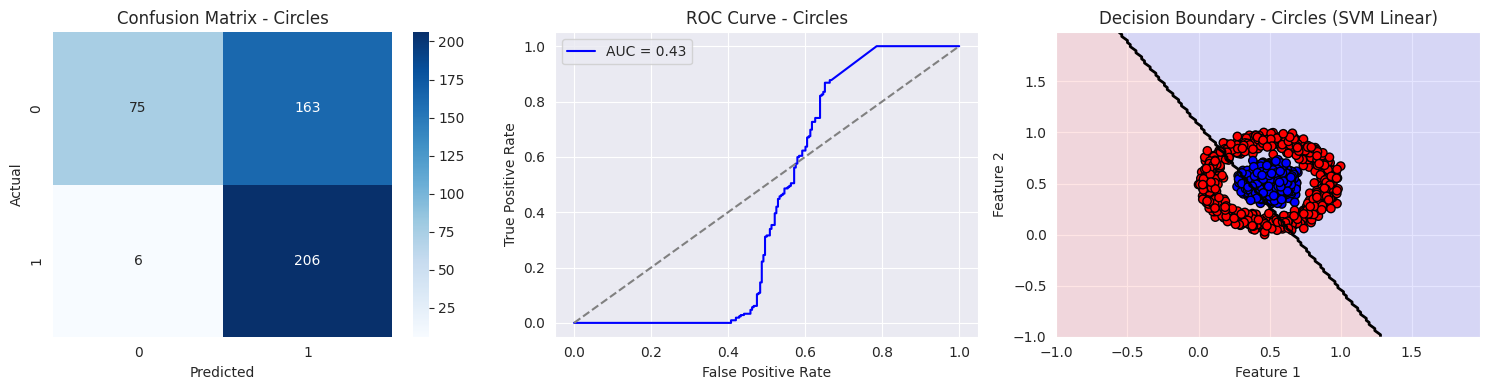

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.32      0.47       238
           1       0.56      0.97      0.71       212

    accuracy                           0.62       450
   macro avg       0.74      0.64      0.59       450
weighted avg       0.75      0.62      0.58       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Random - SVM Linear
Accuracy (cross-validation): 0.5273 ± 0.0013


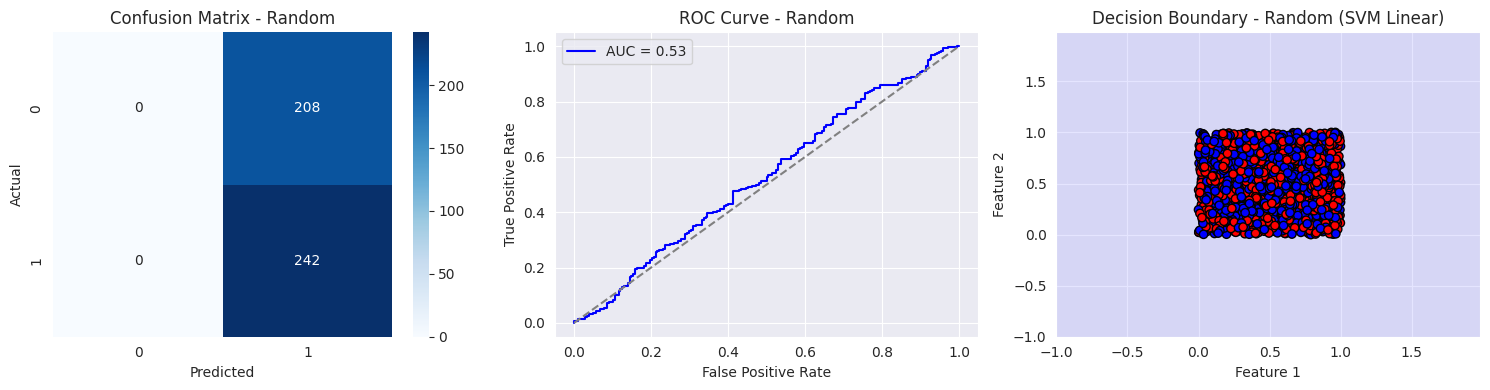

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       208
           1       0.54      1.00      0.70       242

    accuracy                           0.54       450
   macro avg       0.77      0.50      0.35       450
weighted avg       0.75      0.54      0.38       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Chess - SVM Linear
Accuracy (cross-validation): 0.6760 ± 0.0013


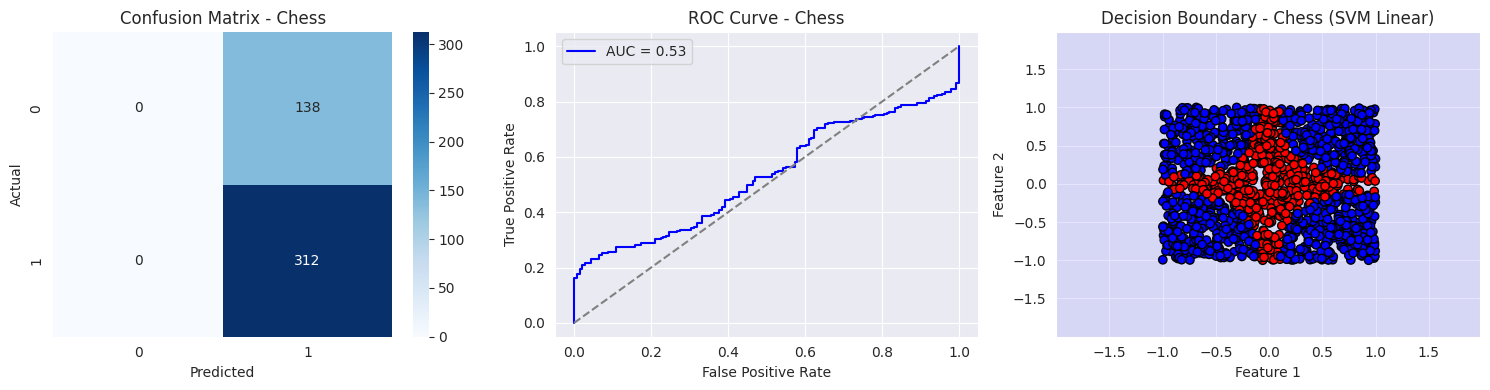

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       138
           1       0.69      1.00      0.82       312

    accuracy                           0.69       450
   macro avg       0.85      0.50      0.41       450
weighted avg       0.79      0.69      0.57       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


In [17]:
evaluate_model(SVC(kernel="linear", probability=True), "SVM Linear", datasets)


Seperated - SVM RBF
Accuracy (cross-validation): 1.0000 ± 0.0000


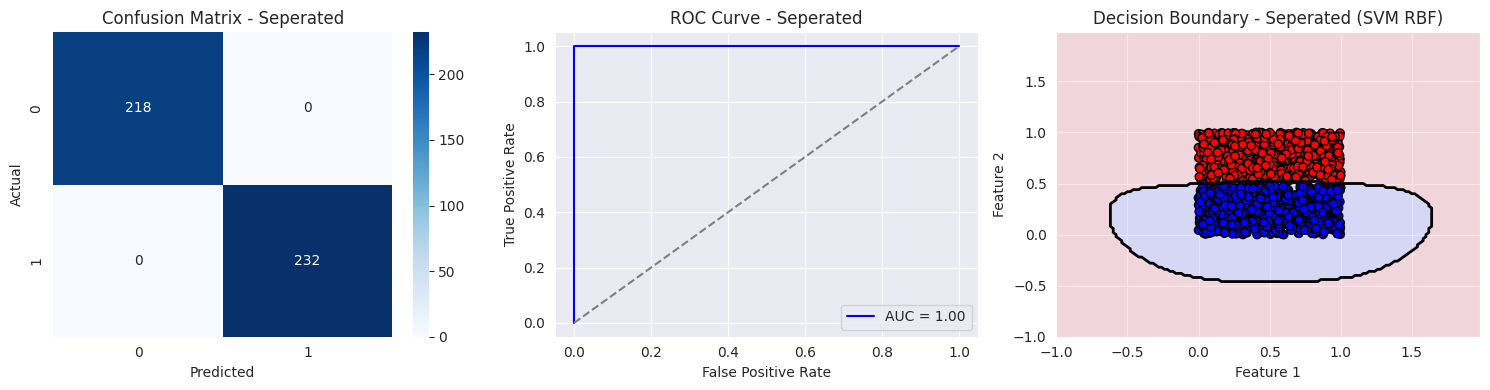

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       218
         1.0       1.00      1.00      1.00       232

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Two Lines - SVM RBF
Accuracy (cross-validation): 0.5887 ± 0.1166


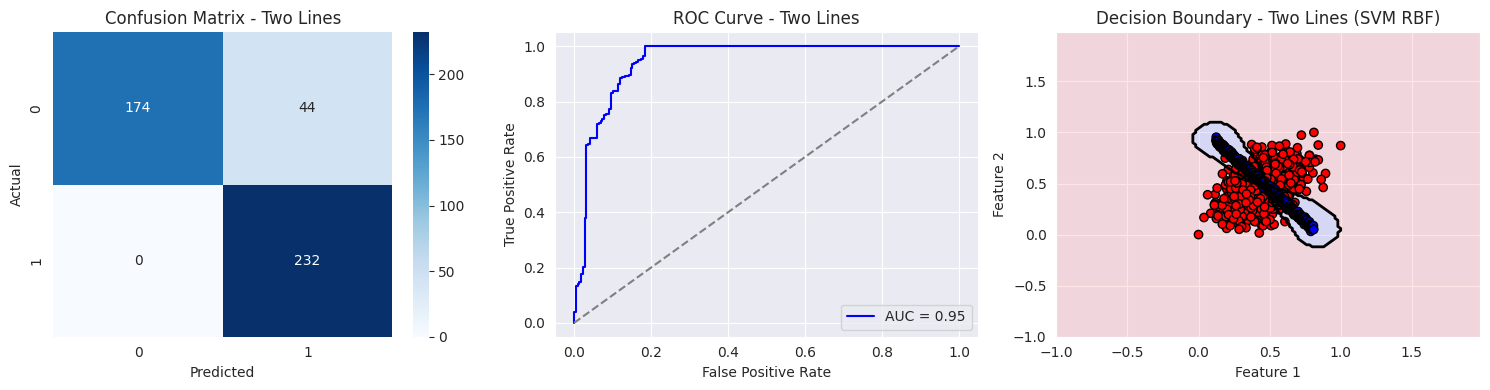

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89       218
         1.0       0.84      1.00      0.91       232

    accuracy                           0.90       450
   macro avg       0.92      0.90      0.90       450
weighted avg       0.92      0.90      0.90       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Moons - SVM RBF
Accuracy (cross-validation): 0.9973 ± 0.0039


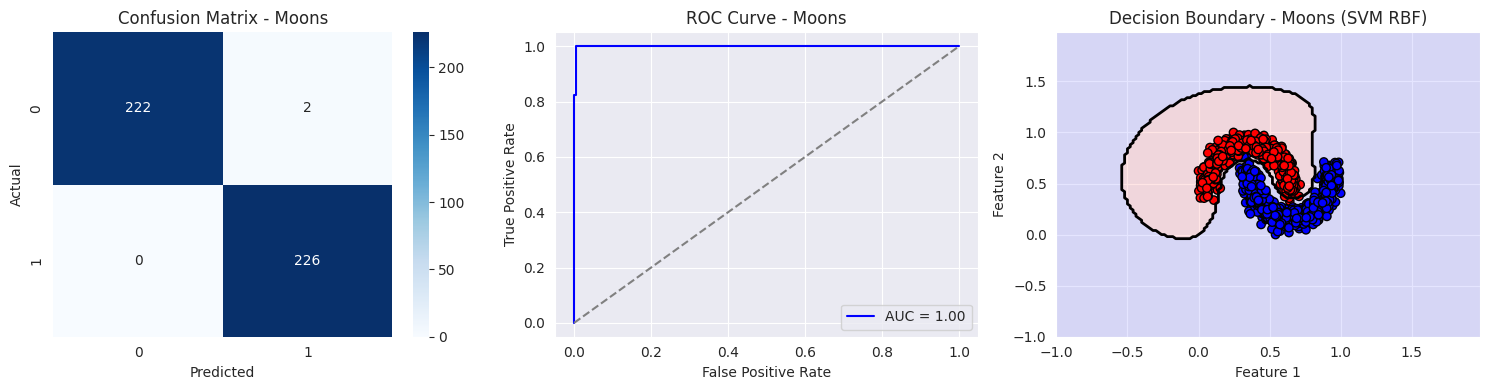

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       224
           1       0.99      1.00      1.00       226

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Circles - SVM RBF
Accuracy (cross-validation): 1.0000 ± 0.0000


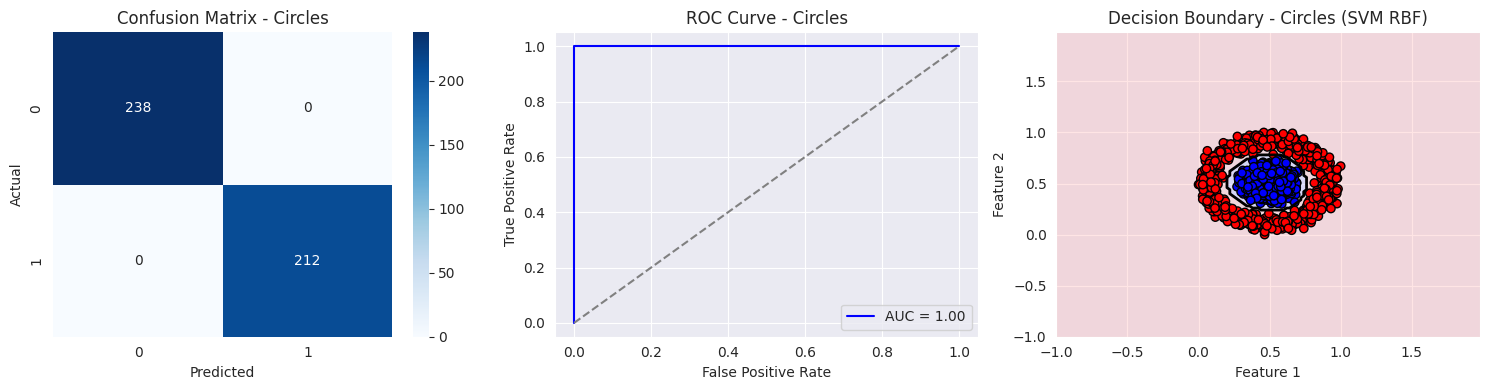

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       1.00      1.00      1.00       212

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Random - SVM RBF
Accuracy (cross-validation): 0.5267 ± 0.0103


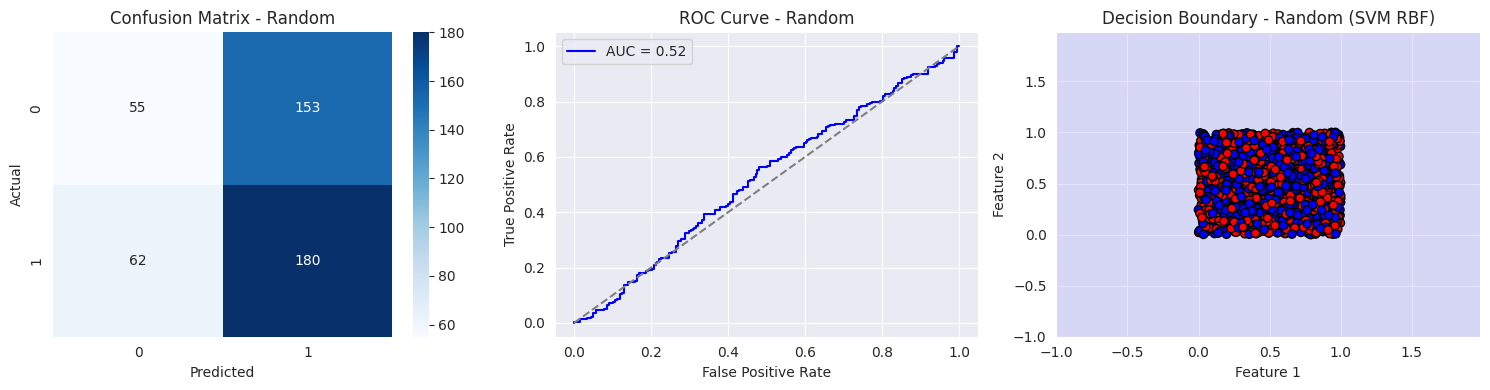

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.26      0.34       208
           1       0.54      0.74      0.63       242

    accuracy                           0.52       450
   macro avg       0.51      0.50      0.48       450
weighted avg       0.51      0.52      0.49       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'

Chess - SVM RBF
Accuracy (cross-validation): 0.8800 ± 0.0152


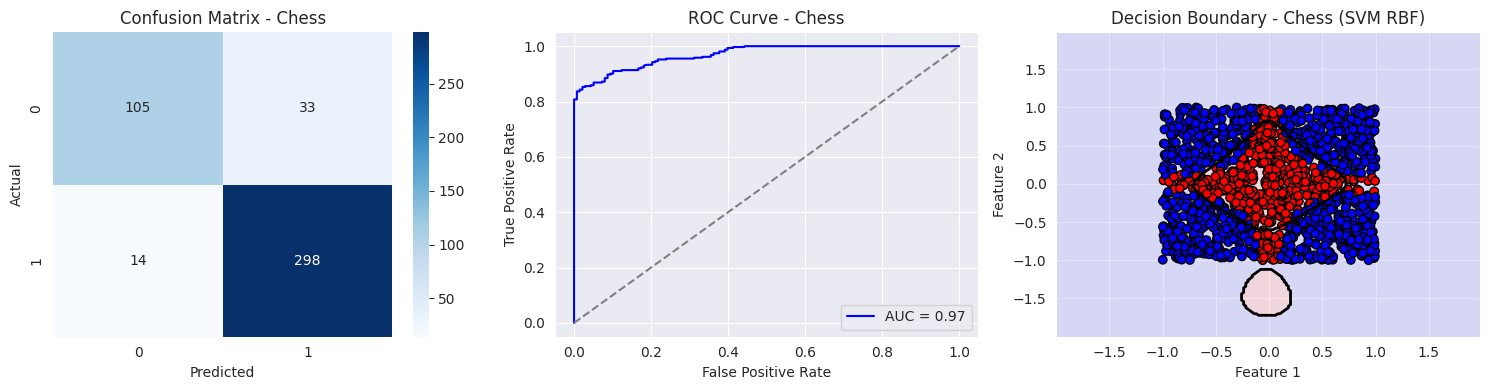

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.76      0.82       138
           1       0.90      0.96      0.93       312

    accuracy                           0.90       450
   macro avg       0.89      0.86      0.87       450
weighted avg       0.89      0.90      0.89       450

Error plotting decision boundary: 'str' object has no attribute 'contourf'


In [18]:
evaluate_model(SVC(kernel="rbf", probability=True), "SVM RBF", datasets)
